<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%); padding: 40px 40px 30px 40px; border-radius: 12px; margin-bottom: 10px;">
<h1 style="color: #e2e8f0; font-size: 2.2em; font-weight: 700; margin: 0 0 8px 0; letter-spacing: -0.5px;">
HOMO-LUMO Gap Prediction from Molecular Structure
</h1>
<h3 style="color: #94a3b8; font-weight: 400; margin: 0 0 20px 0; font-size: 1.1em;">
Machine Learning on the COMPAS-2D Dataset of Heteroaromatic Systems
</h3>
<hr style="border: none; border-top: 1px solid #334155; margin: 20px 0;"/>
<table style="color: #cbd5e1; font-size: 0.92em; border-collapse: collapse; width: 100%;">
<tr><td style="padding: 4px 20px 4px 0; color: #64748b; font-weight: 600;">Dataset</td><td>COMPAS-2D &mdash; 156,000 rows (52,000 neutral, charge=0 molecules used for modelling)</td></tr>
<tr><td style="padding: 4px 20px 4px 0; color: #64748b; font-weight: 600;">Target</td><td>HOMO-LUMO gap (eV) &mdash; frontier orbital energy difference</td></tr>
<tr><td style="padding: 4px 20px 4px 0; color: #64748b; font-weight: 600;">Models</td><td>Linear Regression, Ridge, Lasso, ElasticNet, Random Forest, Gradient Boosting, XGBoost</td></tr>
<tr><td style="padding: 4px 20px 4px 0; color: #64748b; font-weight: 600;">Features</td><td>RDKit molecular descriptors + Morgan fingerprints (1024-bit, radius 2)</td></tr>
<tr><td style="padding: 4px 20px 4px 0; color: #64748b; font-weight: 600;">Splitting</td><td>Murcko scaffold split &mdash; zero scaffold overlap guaranteed</td></tr>
</table>
</div>

---

## A. Problem Statement

The **HOMO-LUMO gap** — the energy difference between the Highest Occupied Molecular Orbital (HOMO) and the Lowest Unoccupied Molecular Orbital (LUMO) — is a central quantity in computational chemistry and materials design. It governs optical absorption, charge transfer, redox behaviour, and the conductivity of organic semiconductors. Traditional computation of this property requires Density Functional Theory (DFT), which scales as O(N³) with molecular size and becomes prohibitively expensive when screening large molecular libraries.

This work asks: **can the HOMO-LUMO gap be accurately predicted from molecular structure alone, using machine learning applied to structural descriptors computed from the 2D molecular graph?** If so, ML models could pre-screen candidate molecules for organic photovoltaics, organic light-emitting diodes, and non-linear optical materials at a fraction of the computational cost of DFT.

The **COMPAS-2D dataset** The COMPAS-2D dataset contains 156,000 entries spanning neutral, cationic, and anionic charge states. After restricting to neutral molecules (charge = 0) with valid DFT-computed gap values — the physically meaningful subset for ground-state electronic property prediction — 52,000 molecules remain. This filtered set constitutes the working population for all experiments in this study. These cata-condensed heteroaromatic molecules with DFT-computed properties, covering a wide range of gap values (≈1–7 eV) and incorporating atoms from B, C, N, O, and S. The dataset's deliberate inclusion of boron-doped systems introduces a chemically meaningful challenge, as boron's electron deficiency produces qualitatively different electronic behaviour from purely carbon/nitrogen frameworks.

---

## B. Research Objectives

1. **Predictive modelling** — Develop and compare seven regression models spanning linear methods and gradient-boosted ensemble methods for HOMO-LUMO gap prediction from structural features only.

2. **Sampling strategy analysis** — Evaluate whether the method of selecting a 5,000-molecule working subset from 52,000 candidates (random vs. stratified vs. boron-balanced) materially affects model performance and generalisation.

3. **Boron effect investigation** — Conduct controlled experiments separating boron-containing and boron-free subsets to determine whether boron constitutes a genuine chemical signal or a statistical shortcut for the models.

4. **Feature interpretation** — Identify which structural descriptors and Morgan fingerprint substructures drive predictions, and explain these through frontier orbital chemistry.

5. **Generalisation assessment** — Use Murcko scaffold splitting to estimate realistic performance on novel molecular scaffolds, and validate stability across multiple random seeds.

---

## C. Approach & Methodology

### C-1 Data Leakage Prevention
The COMPAS-2D dataset includes DFT-computed properties (`homo`, `lumo`, `aip`, `aea`, etc.) alongside structural columns. All quantum-chemical output columns are excluded from the feature set. Models are trained exclusively on structure-derived features, ensuring genuine structure-to-property learning rather than trivial look-up.

### C-2 Three Sampling Strategies
A working subset of 5,000 molecules is selected under three protocols, enabling systematic comparison:
- **Strategy A (Random):** Uniform random selection — establishes a naive baseline.
- **Strategy B (Stratified):** Quantile-based stratification into 10 gap bins, sampled proportionally — ensures full distribution coverage.
- **Strategy C (Boron-balanced):** 2,500 boron + 2,500 non-boron molecules, each stratified — controls for boron class imbalance.

### C-3 Feature Engineering
Two complementary feature sets are concatenated into a single design matrix:
- **RDKit molecular descriptors** (~200 physicochemical properties: MW, logP, TPSA, ring counts, hydrogen-bonding capacity, topological indices).
- **Morgan circular fingerprints** (1024-bit, radius 2) — encode presence/absence of local substructural fragments up to 2 bonds from each atom.

### C-4 Train/Test Splitting
All splits use **Murcko scaffold decomposition**: molecules sharing the same core ring system are assigned entirely to train or test, never split across both. This prevents the model from exploiting structural similarity between train and test molecules and produces a conservative, realistic performance estimate. Zero scaffold overlap between train and test is verified programmatically for every split.

### C-5 Model Training & Tuning
All seven models share an identical preprocessing pipeline: `[SimpleImputer(median) → RobustScaler → model]`. Hyperparameter optimisation uses `RandomizedSearchCV` with a uniform budget of **n_iter=30, cv=3** for every model, ensuring fair comparison. Tuning is performed on the Strategy B training set; tuned models are then evaluated on all three strategies' test sets.

### C-6 Analysis Dimensions
Beyond performance metrics, the analysis covers: intrinsic and permutation feature importance for all seven models; controlled boron-only and boron-free sub-experiments; structural visualisation of best and worst predicted molecules; Morgan fingerprint rarity analysis; molecular topology comparison; and multi-seed robustness validation (seeds 42, 123, 777).

---

## D. Analysis Pipeline

| Stage | Description |
|:---:|:---|
| 1 | Environment setup and data loading |
| 2 | Exploratory data analysis and electronic property correlations |
| 3 | Three sampling strategies with distribution visualisation |
| 4 | Feature engineering: RDKit descriptors + Morgan fingerprints |
| 5 | Murcko scaffold-based train/test splitting |
| 6 | Baseline training: all 7 models × all 3 strategies (21 combinations) |
| 7 | Hyperparameter tuning: all 7 models, uniform search budget |
| 8 | Cross-strategy evaluation of tuned models |
| 9 | Feature importance: coefficient magnitude, MDI, and permutation |
| 10 | Boron-only controlled experiment |
| 11 | Boron-free controlled experiment |
| 12 | Three-way boron comparison |
| 13 | Train vs. test scatter plots and overfit quantification |
| 14 | Structural outlier analysis with molecular visualisation |
| 15 | Molecular topology analysis across all models |
| 16 | Multi-seed robustness validation |
| 17 | Comprehensive sampling strategy comparison |
| 18 | Chemical reasoning and mechanistic discussion |
| 19 | Final results summary and conclusions |


---
## Stage 1 — Environment Setup & Data Loading

All required libraries are imported and global experimental constants are defined. `RDKit` provides cheminformatics functionality including molecular parsing, descriptor computation, fingerprint generation, and scaffold extraction. `scikit-learn` provides the ML pipeline infrastructure. `XGBoost` is loaded conditionally to allow execution in environments where it may not be installed.

Two global constants govern the entire experiment: `RANDOM_STATE = 42` ensures full reproducibility; `N_ITER_SEARCH = 30` sets the hyperparameter search budget **identically for all seven models** — a deliberate design choice ensuring no model receives preferential treatment during tuning.

In [1]:
# ── Dependencies ──────────────────────────────────────────────────────────────
# Uncomment to install if needed:
# !pip install rdkit-pypi xgboost

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
from collections import defaultdict
from IPython.display import display

from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance as sk_permutation_importance
from scipy.stats import randint, uniform, loguniform

RDLogger.DisableLog('rdApp.*')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 110

RANDOM_STATE = 42
N_ITER_SEARCH = 30   # ← UNIFORM for ALL models — ensures fair hyperparameter search budget
CV_FOLDS = 3

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
    print("✓ XGBoost available")
except ImportError:
    HAS_XGB = False
    print("⚠ XGBoost not available — 6 models will be used")

print("✓ All imports successful")
print(f"  Random state : {RANDOM_STATE}")
print(f"  Search iter  : {N_ITER_SEARCH} (same for ALL models)")
print(f"  CV folds     : {CV_FOLDS}")


✓ XGBoost available
✓ All imports successful
  Random state : 42
  Search iter  : 30 (same for ALL models)
  CV folds     : 3


In [2]:
# ── Load Dataset ──────────────────────────────────────────────────────────────
RAW_URL = "https://gitlab.com/porannegroup/compas/-/raw/main/COMPAS-2/compas-2D.csv"
# RAW_URL = "path/to/local/compas-2D.csv"  # Use this for offline runs

print("Loading COMPAS-2D dataset...")
df_raw = pd.read_csv(RAW_URL)
print(f"✓ Loaded {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"  Columns: {list(df_raw.columns)}")

# Keep only neutral molecules with valid gap
df = df_raw[(df_raw['charge'] == 0) & (df_raw['gap'].notna())].reset_index(drop=True)
print(f"✓ After filtering: {df.shape[0]:,} neutral molecules with valid gap")


Loading COMPAS-2D dataset...
✓ Loaded 156,000 rows × 40 columns
  Columns: ['Unnamed: 0', 'name', 'charge', 'formula', 'inchi', 'smiles', 'rings', 'aromatic_rings', 'atoms', 'heteroatoms', 'heterocycles', 'branch', 'cyclobutadiene', 'pyrrole', 'borole', 'furan', 'thiophene', 'dhdiborinine', '14diborinine', 'pyrazine', 'pyridine', 'borinine', 'benzene', 'h', 'c', 'b', 's', 'o', 'n', 'homo', 'lumo', 'homo-1', 'lumo+1', 'gap', 'dispersion', 'energy', 'aip', 'aea', 'dipole', 'rmsd']
✓ After filtering: 52,000 neutral molecules with valid gap


---
## Stage 1b — Feature Selection and Data Leakage Prevention

The COMPAS-2D dataset contains both structural annotations and DFT-computed quantum chemical outputs in the same table. The target variable (HOMO-LUMO `gap`) is itself a DFT output, and related quantities — `homo`, `lumo`, `aip`, `aea`, `homo-1`, `lumo+1` — are products of the same calculations. Including any of these as input features would constitute **direct data leakage**: a model could simply learn the identity `gap = lumo − homo` without learning anything about molecular structure, achieving near-perfect accuracy that would be meaningless in practice.

All DFT-computed columns are therefore excluded from the feature matrix. The model is permitted to use only:
- Structural annotations already present in the dataset (atom counts, ring counts — quantities derivable from the molecular graph)
- RDKit-computed molecular descriptors (calculated fresh from the SMILES string)
- Morgan fingerprints (calculated fresh from the SMILES string)

This guarantees the task remains a genuine structure-to-property prediction problem.


In [3]:
# ── Column identification & leakage prevention ────────────────────────────────
SMILES_COL = 'smiles'
TARGET_COL  = 'gap'

# These are DFT-computed quantum properties — EXCLUDED to prevent data leakage
# Including homo/lumo would trivially solve gap = lumo - homo
DFT_COLS  = ['homo', 'lumo', 'homo-1', 'lumo+1', 'gap', 'aip', 'aea',
             'dispersion', 'energy', 'rmsd']
META_COLS = ['Unnamed: 0', 'charge']
EXCLUDE_COLS = set(DFT_COLS + META_COLS + [SMILES_COL, 'has_boron'])

# Structural features already present in the dataset
structural_features = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in EXCLUDE_COLS
]

PROPERTY_COLS = [c for c in ['homo', 'lumo', 'gap', 'aip', 'aea'] if c in df.columns]

print(f"Target               : '{TARGET_COL}'")
print(f"DFT columns excluded : {[c for c in DFT_COLS if c in df.columns]}")
print(f"Structural features  : {len(structural_features)}")
print(f"  Examples: {structural_features[:5]}")
print(f"\nData leakage check: HOMO/LUMO/AIP excluded ✓")


Target               : 'gap'
DFT columns excluded : ['homo', 'lumo', 'homo-1', 'lumo+1', 'gap', 'aip', 'aea', 'dispersion', 'energy', 'rmsd']
Structural features  : 23
  Examples: ['rings', 'aromatic_rings', 'atoms', 'heteroatoms', 'heterocycles']

Data leakage check: HOMO/LUMO/AIP excluded ✓


---
## Stage 2 — Exploratory Data Analysis

Before modelling, the distribution of the target variable and the relationships between electronic properties are examined. This serves two purposes: confirming data quality, and informing model selection based on the underlying chemical structure of the problem.

**Target distribution:** The HOMO-LUMO gap spans approximately 1–7 eV across the dataset. The distribution is roughly unimodal but with a visible shoulder attributable to boron-containing molecules, which cluster at lower gap values due to boron's electron-withdrawing character. Understanding this distributional structure motivates the stratified and boron-balanced sampling strategies.

**Chemical context:** Small gaps (< 2 eV) correspond to molecules with significant π-conjugation and narrow frontier orbital separation — relevant for organic semiconductor applications. Large gaps (> 4 eV) correspond to more localised, insulating systems. The full range must be represented in the training set for a model to generalise across the chemical space.


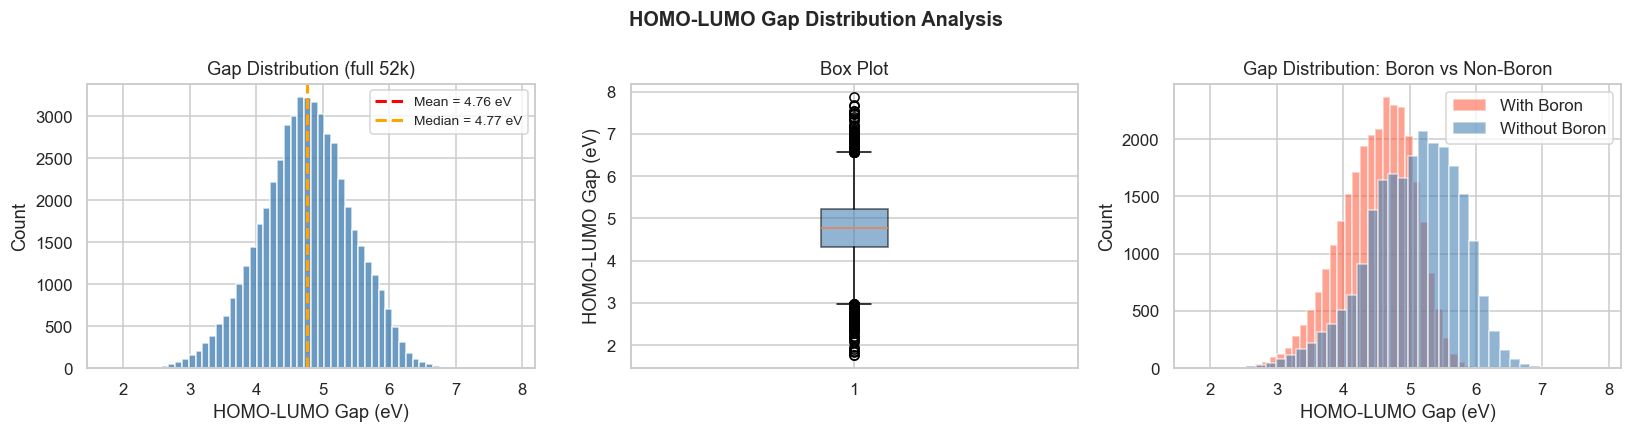

count    52000.0000
mean         4.7592
std          0.6834
min          1.7590
25%          4.3159
50%          4.7680
75%          5.2155
max          7.8843
Name: gap, dtype: float64

Boron-containing: 28,652 (55.1%)
Non-boron        : 23,348 (44.9%)

Boron mean gap   : 4.507 eV
Non-boron mean gap: 5.069 eV


In [4]:
# ── Target distribution ───────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(df[TARGET_COL], bins=60, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(df[TARGET_COL].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {df[TARGET_COL].mean():.2f} eV')
axes[0].axvline(df[TARGET_COL].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median = {df[TARGET_COL].median():.2f} eV')
axes[0].set_xlabel('HOMO-LUMO Gap (eV)'); axes[0].set_ylabel('Count')
axes[0].set_title('Gap Distribution (full 52k)'); axes[0].legend(fontsize=9)

# Boxplot
axes[1].boxplot(df[TARGET_COL], vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6))
axes[1].set_ylabel('HOMO-LUMO Gap (eV)'); axes[1].set_title('Box Plot')

# Boron vs non-boron distribution
def has_boron(smi):
    if not isinstance(smi, str): return False
    return bool(re.search(r'B(?!r)', smi))  # B not followed by r (not Br)

df['has_boron'] = df[SMILES_COL].apply(has_boron)
df[df['has_boron']][TARGET_COL].hist(ax=axes[2], bins=40, alpha=0.6, label='With Boron', color='tomato')
df[~df['has_boron']][TARGET_COL].hist(ax=axes[2], bins=40, alpha=0.6, label='Without Boron', color='steelblue')
axes[2].set_xlabel('HOMO-LUMO Gap (eV)'); axes[2].set_ylabel('Count')
axes[2].set_title('Gap Distribution: Boron vs Non-Boron'); axes[2].legend()

plt.suptitle('HOMO-LUMO Gap Distribution Analysis', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

print(df[TARGET_COL].describe().round(4))
print(f"\nBoron-containing: {df['has_boron'].sum():,} ({df['has_boron'].mean()*100:.1f}%)")
print(f"Non-boron        : {(~df['has_boron']).sum():,} ({(~df['has_boron']).mean()*100:.1f}%)")
print(f"\nBoron mean gap   : {df[df['has_boron']][TARGET_COL].mean():.3f} eV")
print(f"Non-boron mean gap: {df[~df['has_boron']][TARGET_COL].mean():.3f} eV")


### Electronic Property Correlations

The correlation heatmap examines relationships between the DFT-computed quantum properties. While these properties are excluded from modelling, understanding their correlations provides chemical insight relevant to feature importance interpretation and model selection.

**HOMO ↔ AIP (r ≈ −0.96):** The adiabatic ionisation potential measures the energy required to remove an electron from the neutral ground-state molecule. This electron comes from the HOMO. The two quantities measure the same physical process: one as an orbital energy (negative by convention), the other as an experimental ionisation energy (positive). The near-perfect anti-correlation is therefore chemically expected and serves as a data quality check.

**LUMO ↔ AEA:** The adiabatic electron affinity measures the stabilisation gained when an electron is added to the neutral molecule. That electron occupies the LUMO. The correlation between AEA and LUMO energy reflects the same one-to-one physical correspondence.

**Implication for modelling:** Molecular descriptors exhibit analogous inter-correlations — molecular weight correlates with ring count, ring count with conjugation length, conjugation length with the HOMO-LUMO gap. This multicollinearity is the primary reason linear models underperform tree-based methods on this dataset. Linear models attempt to fit a coefficient to each correlated feature simultaneously, producing unstable, inflated coefficients. Tree models select the single most informative feature at each split, sidestepping the problem entirely.


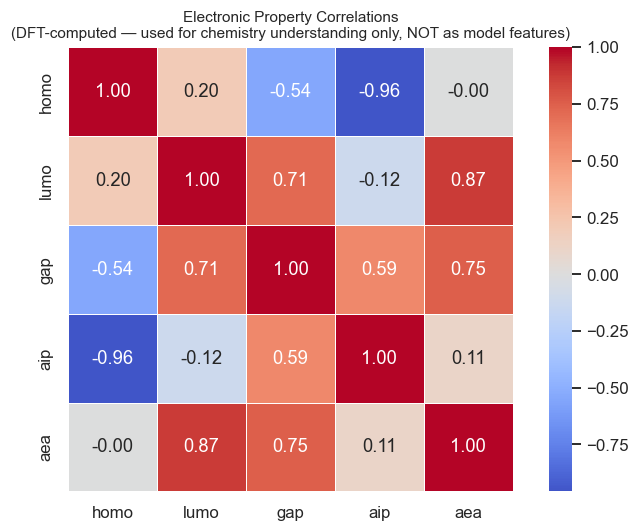


Strongest correlations:
  homo     ↔ aip     : r = -0.957
  lumo     ↔ aea     : r = +0.871
  gap      ↔ aea     : r = +0.748
  lumo     ↔ gap     : r = +0.711
  gap      ↔ aip     : r = +0.585


In [5]:
# ── Correlation heatmap ───────────────────────────────────────────────────────
if len(PROPERTY_COLS) > 1:
    corr = df[PROPERTY_COLS].corr()
    plt.figure(figsize=(7, 5))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                linewidths=0.5, square=True)
    plt.title('Electronic Property Correlations\n(DFT-computed — used for chemistry understanding only, NOT as model features)',
              fontsize=10)
    plt.tight_layout(); plt.show()
    
    print("\nStrongest correlations:")
    corr_pairs = []
    for i in range(len(PROPERTY_COLS)):
        for j in range(i+1, len(PROPERTY_COLS)):
            r = corr.iloc[i, j]
            corr_pairs.append((PROPERTY_COLS[i], PROPERTY_COLS[j], r))
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for a, b, r in corr_pairs[:5]:
        print(f"  {a:8s} ↔ {b:8s}: r = {r:+.3f}")


---
## Stage 3 — Data Sampling Strategies

The raw COMPAS-2D dataset contains 156,000 rows representing molecules across multiple charge states (neutral, cationic, anionic). After filtering to retain only neutral molecules (charge = 0) with a valid HOMO-LUMO gap value, 52,000 molecules remain. This filtered set of 52,000 is the working population from which all sampling is performed. Working with the full 52,000-molecule neutral subset is computationally feasible but unnecessary for method comparison. A 5,000-molecule working subset is selected under three protocols, each embodying a different assumption about what constitutes a representative training set.

**Strategy A — Pure Random (Baseline):**  
Uniform random selection without stratification. Oversamples dense regions of the gap distribution (mid-range values dominate the dataset) and undersamples rare large-gap and small-gap molecules. Provides a naive baseline against which the other strategies are benchmarked.

**Strategy B — Stratified by Gap Distribution:**  
The gap range is divided into 10 quantile-based bins, and molecules are sampled proportionally from each bin. This guarantees representation of the full gap range — including molecules at the distribution extremes that are statistically rare but chemically important. Strategy B is used as the primary dataset for hyperparameter tuning due to its distributional completeness.

**Strategy C — Boron-Balanced:**  
Exactly 2,500 boron-containing and 2,500 boron-free molecules are selected, each group independently stratified across the gap distribution. Since boron presence is a dominant predictor (confirmed in Stage 9), the neutral subset contains ≈55% boron-containing molecules — a majority rather than a minority. Random and stratified samples therefore already over-represent boron relative to the broader chemical space. Strategy C enforces an exact 50/50 split to test whether model performance and feature rankings change when boron class balance is controlled.

All three strategies select exactly N = 5,000 molecules, enabling direct performance comparison. Note that Strategies A and B naturally reflect the dataset's ≈55% boron composition, while Strategy C deliberately oversamples non-boron molecules to achieve balance.

Sampling summary:
  Strategy A (Random): n=5,000  μ=4.753  σ=0.691  boron=56%
  Strategy B (Stratified): n=5,000  μ=4.762  σ=0.681  boron=55%
  Strategy C (Boron-balanced): n=5,000  μ=4.789  σ=0.688  boron=50%


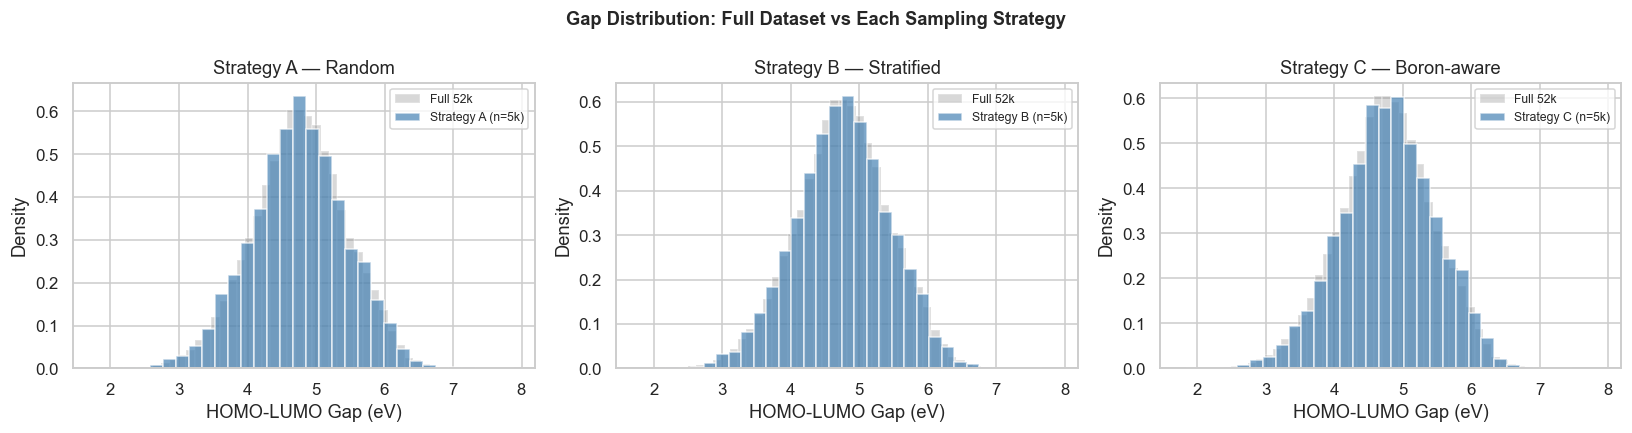

In [6]:
# ── Stratified sampling function ─────────────────────────────────────────────
def stratified_gap_sample(df_source, n_total, seed=RANDOM_STATE):
    """Sample n_total molecules proportionally from 10 quantile bins of gap distribution."""
    df_copy = df_source.copy()
    df_copy['_bin'] = pd.qcut(df_copy[TARGET_COL], q=10, labels=False, duplicates='drop')
    n_bins = df_copy['_bin'].nunique()
    per_bin = n_total // n_bins
    frames = []
    for _, grp in df_copy.groupby('_bin'):
        frames.append(grp.sample(n=min(len(grp), per_bin), random_state=seed))
    result = pd.concat(frames).drop(columns=['_bin']).reset_index(drop=True)
    # Top up to exactly n_total if needed
    if len(result) < n_total:
        remaining = df_source.drop(index=result.index, errors='ignore')
        extra = remaining.sample(n=min(n_total - len(result), len(remaining)), random_state=seed)
        result = pd.concat([result, extra]).reset_index(drop=True)
    return result

SAMPLE_N = 5000

# Strategy A — Pure random
df_A = df.sample(n=SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

# Strategy B — Stratified by gap
df_B = stratified_gap_sample(df, SAMPLE_N)

# Strategy C — Balanced boron: 2500 with + 2500 without, each stratified
df_boron    = df[df['has_boron']].copy()
df_no_boron = df[~df['has_boron']].copy()
df_C = pd.concat([
    stratified_gap_sample(df_boron,    SAMPLE_N // 2),
    stratified_gap_sample(df_no_boron, SAMPLE_N // 2)
]).reset_index(drop=True)

print("Sampling summary:")
for name, dset in [('A (Random)', df_A), ('B (Stratified)', df_B), ('C (Boron-balanced)', df_C)]:
    gap = dset[TARGET_COL]
    boron_pct = dset['has_boron'].mean() * 100
    print(f"  Strategy {name}: n={len(dset):,}  μ={gap.mean():.3f}  σ={gap.std():.3f}  boron={boron_pct:.0f}%")

# Visualise distributions of all three strategies
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, dset) in zip(axes, [('A — Random', df_A), ('B — Stratified', df_B), ('C — Boron-aware', df_C)]):
    ax.hist(df[TARGET_COL], bins=50, alpha=0.3, color='gray', label='Full 52k', density=True)
    ax.hist(dset[TARGET_COL], bins=30, alpha=0.7, color='steelblue', label=f'Strategy {name[0]} (n=5k)', density=True)
    ax.set_xlabel('HOMO-LUMO Gap (eV)'); ax.set_ylabel('Density')
    ax.set_title(f'Strategy {name}'); ax.legend(fontsize=8)
plt.suptitle('Gap Distribution: Full Dataset vs Each Sampling Strategy', fontsize=12, fontweight='bold')
plt.tight_layout(); plt.show()


---
## Stage 4 — Feature Engineering

All features are computed directly from the molecular SMILES string using RDKit, ensuring no quantum-chemical information enters the feature matrix. Two complementary representations are concatenated into a single design matrix.

**RDKit Molecular Descriptors (~200 features):**  
Physicochemical properties derived from the molecular graph: molecular weight, lipophilicity (logP), topological polar surface area, ring counts, aromatic ring counts, hydrogen bond donors and acceptors, rotatable bonds, and a range of topological connectivity indices (Chi, Kappa, Balaban J). These descriptors capture global molecular properties and are directly interpretable in chemical terms.

**Morgan Circular Fingerprints (1024 bits, radius 2):**  
Each bit encodes the presence or absence of a specific circular substructural fragment extending up to 2 bonds from each atom. At radius 2, a bit may represent, for example, a nitrogen atom bonded to two aromatic carbons within a fused ring system. When a fingerprint bit appears in the top feature importance rankings, it can be decoded back to a chemical substructure — making the model's learning interpretable in structural terms.

**Design rationale:** Descriptors provide global molecular context (size, polarity, saturation); fingerprints provide local substructural resolution. Together they allow the model to exploit both molecular-level properties and specific structural motifs. Infinite and undefined descriptor values are replaced with NaN prior to feature matrix construction; all NaN values are imputed within the pipeline using training-set medians to prevent any test-set information from influencing imputation.


In [7]:
# ── Feature engineering functions ────────────────────────────────────────────
def smiles_to_rdkit_descriptors(smiles_list):
    """Compute all RDKit descriptors for a list of SMILES strings."""
    desc_names = [d[0] for d in Descriptors.descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
    records = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi) if isinstance(smi, str) else None
        if mol:
            records.append(list(calculator.CalcDescriptors(mol)))
        else:
            records.append([np.nan] * len(desc_names))
    return pd.DataFrame(records, columns=desc_names)

def smiles_to_morgan_fingerprints(smiles_list, radius=2, n_bits=1024):
    """Compute Morgan (circular) fingerprints — each bit = structural fragment."""
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi) if isinstance(smi, str) else None
        if mol:
            fps.append(list(AllChem.GetMorganFingerprintAsBitVect(mol, radius, n_bits)))
        else:
            fps.append([0] * n_bits)
    return pd.DataFrame(fps, columns=[f'fp_{i}' for i in range(n_bits)])

def build_features(df_sample):
    """Build full feature matrix: structural features + RDKit descriptors + Morgan FPs."""
    print(f"  Building features for {len(df_sample):,} molecules...")
    rdkit_desc = smiles_to_rdkit_descriptors(df_sample[SMILES_COL].tolist())
    morgan_fps  = smiles_to_morgan_fingerprints(df_sample[SMILES_COL].tolist())
    
    # Structural features already in dataset (non-DFT)
    X_struct = df_sample[structural_features].replace([np.inf, -np.inf], np.nan).reset_index(drop=True)
    # RDKit descriptors (replace inf with NaN — imputer handles NaN inside pipeline)
    X_desc = rdkit_desc.replace([np.inf, -np.inf], np.nan).reset_index(drop=True)
    X_fp   = morgan_fps.reset_index(drop=True)
    
    X = pd.concat([X_struct, X_desc, X_fp], axis=1)
    y = df_sample[TARGET_COL].values
    print(f"  ✓ Feature matrix: {X.shape}  |  target: {y.shape}")
    nan_pct = X.isna().mean().mean() * 100
    print(f"  NaN proportion: {nan_pct:.1f}% (handled by median imputation in pipeline)")
    return X, y

print("Building features — Strategy A:"); X_A, y_A = build_features(df_A)
print("Building features — Strategy B:"); X_B, y_B = build_features(df_B)
print("Building features — Strategy C:"); X_C, y_C = build_features(df_C)


Building features — Strategy A:
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.4% (handled by median imputation in pipeline)
Building features — Strategy B:
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.4% (handled by median imputation in pipeline)
Building features — Strategy C:
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.4% (handled by median imputation in pipeline)


---
## Stage 5 — Scaffold-Based Train/Test Splitting

Standard random train/test splitting is insufficient for molecular machine learning. Because COMPAS-2D molecules are systematically generated by substituting heteroatoms into polycyclic ring frameworks, many molecules share the same core scaffold with only minor peripheral differences. A random split would distribute molecules with nearly identical scaffolds across both train and test sets, enabling the model to achieve high test performance by pattern-matching to near-duplicate training examples rather than genuine generalisation.

**Murcko scaffold splitting** addresses this by extracting the core ring system (Murcko scaffold) from each molecule and assigning all molecules sharing the same scaffold exclusively to either the training set or the test set — never both. This enforces generalisation to *structurally novel scaffolds* rather than mere substitution variants of known ones.

The approach is standard practice in computational drug discovery and structure-activity relationship modelling. It produces more conservative R² values than random splitting, but these values are a more realistic estimate of performance on genuinely new chemical matter. Zero scaffold overlap between train and test is verified programmatically after every split.

Each of the three sampling strategies is split independently with an 80/20 train/test ratio. The scaffold split function returns both the feature/target arrays and the aligned source dataframe subsets, enabling correct SMILES retrieval for structural analysis downstream.


In [8]:
# ── Scaffold split ────────────────────────────────────────────────────────────
def get_murcko_scaffold(smiles):
    """Return Murcko scaffold SMILES for a given molecular SMILES."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
    except:
        pass
    return None

def scaffold_split(df_sample, X, y, test_size=0.2, seed=RANDOM_STATE):
    """
    Split molecules by Murcko scaffold.
    Molecules sharing the same scaffold are kept together in train OR test.
    Returns X_tr, X_te, y_tr, y_te, and also the aligned df_sample subsets.
    """
    df_sample = df_sample.reset_index(drop=True)
    X = X.reset_index(drop=True)
    
    scaffolds = df_sample[SMILES_COL].apply(get_murcko_scaffold)
    valid_mask = scaffolds.notna()
    n_invalid = (~valid_mask).sum()
    if n_invalid > 0:
        print(f"  Excluding {n_invalid} molecules with invalid scaffolds")
        df_sample = df_sample[valid_mask].reset_index(drop=True)
        X = X[valid_mask].reset_index(drop=True)
        y = y[valid_mask.values]
        scaffolds = scaffolds[valid_mask].reset_index(drop=True)
    
    # Group molecule indices by scaffold
    scaffold_groups = defaultdict(list)
    for idx, sc in enumerate(scaffolds):
        scaffold_groups[sc].append(idx)
    
    # Randomly assign scaffolds to train/test
    rng = np.random.RandomState(seed)
    scaffold_list = list(scaffold_groups.items())
    rng.shuffle(scaffold_list)
    
    target_test_n = int(test_size * len(df_sample))
    train_idx, test_idx = [], []
    
    for sc, indices in scaffold_list:
        if len(test_idx) < target_test_n:
            test_idx.extend(indices)
        else:
            train_idx.extend(indices)
    
    # Verify no scaffold overlap
    train_scaffolds = set(scaffolds.iloc[train_idx])
    test_scaffolds  = set(scaffolds.iloc[test_idx])
    overlap = len(train_scaffolds & test_scaffolds)
    
    X_tr = X.iloc[train_idx].reset_index(drop=True)
    X_te = X.iloc[test_idx].reset_index(drop=True)
    y_tr = y[train_idx]
    y_te = y[test_idx]
    df_tr = df_sample.iloc[train_idx].reset_index(drop=True)
    df_te = df_sample.iloc[test_idx].reset_index(drop=True)
    
    print(f"  Unique scaffolds: {len(scaffold_groups):,}")
    print(f"  Train: {len(y_tr):,}  Test: {len(y_te):,}  Scaffold overlap: {overlap} ✓")
    
    return X_tr, X_te, y_tr, y_te, df_tr, df_te

print("Strategy A:"); X_tr_A, X_te_A, y_tr_A, y_te_A, df_tr_A, df_te_A = scaffold_split(df_A, X_A, y_A)
print("Strategy B:"); X_tr_B, X_te_B, y_tr_B, y_te_B, df_tr_B, df_te_B = scaffold_split(df_B, X_B, y_B)
print("Strategy C:"); X_tr_C, X_te_C, y_tr_C, y_te_C, df_tr_C, df_te_C = scaffold_split(df_C, X_C, y_C)
feat_names = list(X_tr_B.columns)
print(f"\nFeature space: {len(feat_names)} total features")


Strategy A:
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓
Strategy B:
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓
Strategy C:
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓

Feature space: 1264 total features


---
## Stage 6 — Baseline Training: All 7 Models × All 3 Strategies

Before hyperparameter tuning, all seven models are trained with default parameters on all three sampling strategies, producing 21 model-strategy combinations. This baseline establishes pre-tuning performance rankings and quantifies the raw impact of sampling strategy on model quality.

**Pipeline uniformity:** Every model is wrapped in an identical `Pipeline([SimpleImputer(median), RobustScaler(), model])`. This design choice is critical for fair comparison:
- The imputer is fit exclusively on the training split and applied to test, preventing leakage through imputation
- RobustScaler is applied to all models including tree-based ones; while trees do not require scaling, uniform preprocessing ensures that any observed performance differences reflect model architecture rather than preprocessing asymmetry

Both training R² and test R² are recorded, along with MAE and RMSE, to enable overfit quantification from this earliest stage.

In [9]:
# ── Unified pipeline builder ──────────────────────────────────────────────────
def make_pipeline(model):
    """All models use the same preprocessing pipeline for fairness."""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  RobustScaler()),
        ('model',   model)
    ])

def evaluate_pipe(name, pipe, X_tr, X_te, y_tr, y_te):
    """Fit pipeline, predict, return metrics dict and fitted pipeline."""
    pipe.fit(X_tr, y_tr)
    y_tr_pred = pipe.predict(X_tr)
    y_te_pred = pipe.predict(X_te)
    
    r2_tr  = r2_score(y_tr, y_tr_pred)
    r2_te  = r2_score(y_te, y_te_pred)
    mae_te = mean_absolute_error(y_te, y_te_pred)
    rmse_te= np.sqrt(mean_squared_error(y_te, y_te_pred))
    
    return {
        'Model': name, 'Train R²': r2_tr, 'Test R²': r2_te,
        'MAE': mae_te, 'RMSE': rmse_te, 'Overfit': r2_tr - r2_te,
        'y_te_pred': y_te_pred
    }, pipe

def get_default_models():
    """Return list of (name, model) with default parameters.""", 
    models = [
        ('Linear Regression', LinearRegression()),
        ('Ridge',      Ridge(alpha=1.0, random_state=RANDOM_STATE)),
        ('Lasso',      Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=5000)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=5000)),
        ('Random Forest',     RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)),
        ('Gradient Boosting', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
                                                         max_depth=5, random_state=RANDOM_STATE)),
    ]
    if HAS_XGB:
        models.append(('XGBoost', XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6,
                                               subsample=0.8, random_state=RANDOM_STATE, verbosity=0,
                                               tree_method='hist')))
    return models

MODEL_NAMES = [n for n, _ in get_default_models()]
print(f"Models: {MODEL_NAMES}")
print(f"Strategies: A, B, C  →  {len(MODEL_NAMES)} × 3 = {len(MODEL_NAMES)*3} combinations")


Models: ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'Random Forest', 'Gradient Boosting', 'XGBoost']
Strategies: A, B, C  →  7 × 3 = 21 combinations


In [10]:
# ── Train all models on all strategies (default params) ───────────────────────
strategies_default = {
    'A — Random':       (X_tr_A, X_te_A, y_tr_A, y_te_A),
    'B — Stratified':   (X_tr_B, X_te_B, y_tr_B, y_te_B),
    'C — Boron-aware':  (X_tr_C, X_te_C, y_tr_C, y_te_C),
}

default_results = []

for strat_name, (X_tr, X_te, y_tr, y_te) in strategies_default.items():
    print(f"\n{'='*65}\nStrategy {strat_name}\n{'='*65}")
    for model_name, model in get_default_models():
        pipe = make_pipeline(model)
        metrics, _ = evaluate_pipe(model_name, pipe, X_tr, X_te, y_tr, y_te)
        metrics['Strategy'] = strat_name
        metrics.pop('y_te_pred')  # don't need predictions at this stage
        default_results.append(metrics)
        print(f"  {model_name:25s}  R²={metrics['Test R²']:.4f}  MAE={metrics['MAE']:.4f}  Overfit={metrics['Overfit']:.4f}")

default_df = pd.DataFrame(default_results)
print(f"\n✓ Completed {len(default_results)} model-strategy combinations")

# Pivot table
pivot_r2 = default_df.pivot_table(index='Model', columns='Strategy', values='Test R²')
print("\nDefault Performance (Test R²):")
display(pivot_r2.round(4))



Strategy A — Random
  Linear Regression          R²=0.5954  MAE=0.3264  Overfit=0.2247
  Ridge                      R²=0.6245  MAE=0.3161  Overfit=0.1882
  Lasso                      R²=0.3253  MAE=0.4396  Overfit=0.0265
  ElasticNet                 R²=0.3823  MAE=0.4197  Overfit=0.0291
  Random Forest              R²=0.6500  MAE=0.3128  Overfit=0.3030
  Gradient Boosting          R²=0.6857  MAE=0.2939  Overfit=0.1868
  XGBoost                    R²=0.7091  MAE=0.2796  Overfit=0.2328

Strategy B — Stratified
  Linear Regression          R²=0.6673  MAE=0.3121  Overfit=0.1517
  Ridge                      R²=0.6844  MAE=0.3060  Overfit=0.1286
  Lasso                      R²=0.3161  MAE=0.4621  Overfit=0.0168
  ElasticNet                 R²=0.3888  MAE=0.4371  Overfit=0.0147
  Random Forest              R²=0.6549  MAE=0.3218  Overfit=0.2956
  Gradient Boosting          R²=0.7189  MAE=0.2875  Overfit=0.1523
  XGBoost                    R²=0.7395  MAE=0.2765  Overfit=0.2023

Strategy C — Bo

Strategy           A — Random  B — Stratified  C — Boron-aware
Model                                                         
ElasticNet             0.3823          0.3888           0.4188
Gradient Boosting      0.6857          0.7189           0.6958
Lasso                  0.3253          0.3161           0.3200
Linear Regression      0.5954          0.6673           0.6420
Random Forest          0.6500          0.6549           0.6409
Ridge                  0.6245          0.6844           0.6767
XGBoost                0.7091          0.7395           0.7144

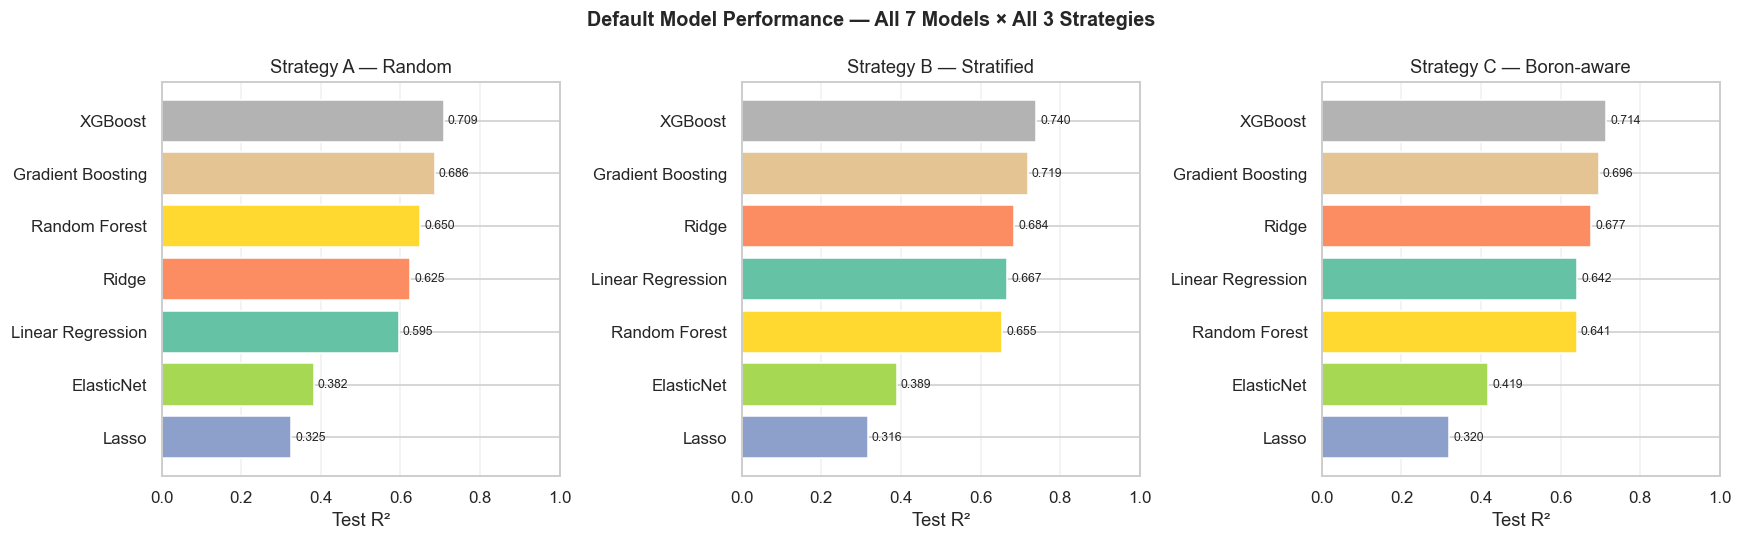

In [11]:
# ── Visualize default performance across strategies ────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

palette = plt.cm.Set2(np.linspace(0, 1, len(MODEL_NAMES)))

for ax, strat in zip(axes, ['A — Random', 'B — Stratified', 'C — Boron-aware']):
    sub = default_df[default_df['Strategy'] == strat].sort_values('Test R²', ascending=True)
    colors_bar = [palette[MODEL_NAMES.index(m)] for m in sub['Model']]
    ax.barh(sub['Model'], sub['Test R²'], color=colors_bar)
    ax.set_xlabel('Test R²'); ax.set_title(f'Strategy {strat}')
    ax.set_xlim(0, 1); ax.grid(axis='x', alpha=0.3)
    for bar, val in zip(ax.patches, sub['Test R²']):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=8)

plt.suptitle('Default Model Performance — All 7 Models × All 3 Strategies', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()


---
## Stage 7 — Hyperparameter Tuning: All 7 Models

Hyperparameter optimisation is performed for all seven models using `RandomizedSearchCV`. The search budget is fixed at **n_iter=30, cv=3** uniformly across all models. This is a deliberate design choice: linear models have 1–2 hyperparameters while tree models have 5–6, meaning the same number of random draws explores a proportionally smaller fraction of the tree model parameter space. Compensating by giving tree models more iterations would introduce a different form of unfairness. The uniform budget represents a clean, defensible baseline; per-model budget scaling is noted as a potential refinement.

**Tuning dataset:** Strategy B (stratified) is used for all hyperparameter searches, as it provides the most balanced representation of the gap distribution and is therefore the most appropriate dataset for finding hyperparameters that generalise across the chemical space.

After tuning, the fitted models are evaluated on the test sets of *all three* sampling strategies — not only Strategy B. This cross-strategy evaluation directly tests whether the tuned hyperparameters are specific to Strategy B's distributional characteristics or genuinely robust.

**Search spaces:** Linear model alphas are sampled from log-uniform distributions spanning multiple orders of magnitude. Tree model parameters (n_estimators, max_depth, learning_rate, subsampling rates, max_features) span ranges informed by empirical best practices for tabular molecular data.

In [12]:
# ── Hyperparameter search spaces ──────────────────────────────────────────────
# n_iter=N_ITER_SEARCH is IDENTICAL for all models (= 30)
# This ensures fair search budget regardless of parameter space size

def run_search(pipe_or_model, param_grid, X_tr, y_tr, label):
    search = RandomizedSearchCV(
        pipe_or_model, param_grid,
        n_iter=N_ITER_SEARCH, cv=CV_FOLDS,
        scoring='r2', n_jobs=-1,
        random_state=RANDOM_STATE, verbose=0
    )
    search.fit(X_tr, y_tr)
    print(f"  Best CV R² ({label}): {search.best_score_:.4f}")
    print(f"  Best params: {search.best_params_}")
    return search.best_estimator_

X_tr_tune, X_te_tune = X_tr_B, X_te_B
y_tr_tune, y_te_tune = y_tr_B, y_te_B
print(f"Tuning dataset: Strategy B  Train={len(y_tr_tune):,}  Test={len(y_te_tune):,}")
print(f"Search budget : n_iter={N_ITER_SEARCH}, cv={CV_FOLDS} — SAME for ALL models\n")

# ── [1/7] Linear Regression — no hyperparameters ──────────────────────────────
print("[1/7] Linear Regression — no hyperparameters to tune")
lr_best = make_pipeline(LinearRegression())
lr_best.fit(X_tr_tune, y_tr_tune)

# ── [2/7] Ridge ───────────────────────────────────────────────────────────────
print("\n[2/7] Ridge")
ridge_best = run_search(
    make_pipeline(Ridge(random_state=RANDOM_STATE)),
    {'model__alpha': loguniform(1e-3, 1e3)},
    X_tr_tune, y_tr_tune, 'Ridge'
)

# ── [3/7] Lasso ───────────────────────────────────────────────────────────────
print("\n[3/7] Lasso")
lasso_best = run_search(
    make_pipeline(Lasso(random_state=RANDOM_STATE, max_iter=10000)),
    {'model__alpha': loguniform(1e-4, 1e1)},
    X_tr_tune, y_tr_tune, 'Lasso'
)

# ── [4/7] ElasticNet ──────────────────────────────────────────────────────────
print("\n[4/7] ElasticNet")
enet_best = run_search(
    make_pipeline(ElasticNet(random_state=RANDOM_STATE, max_iter=10000)),
    {'model__alpha': loguniform(1e-4, 1e1), 'model__l1_ratio': uniform(0.05, 0.9)},
    X_tr_tune, y_tr_tune, 'ElasticNet'
)

# ── [5/7] Random Forest ───────────────────────────────────────────────────────
print("\n[5/7] Random Forest")
rf_best = run_search(
    make_pipeline(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)),
    {
        'model__n_estimators': randint(300, 1500),
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': uniform(0.2, 0.6)
    },
    X_tr_tune, y_tr_tune, 'Random Forest'
)

# ── [6/7] Gradient Boosting ───────────────────────────────────────────────────
print("\n[6/7] Gradient Boosting")
gb_best = run_search(
    make_pipeline(GradientBoostingRegressor(random_state=RANDOM_STATE)),
    {
        'model__n_estimators': randint(200, 800),
        'model__learning_rate': uniform(0.01, 0.18),
        'model__max_depth': randint(3, 8),
        'model__min_samples_split': randint(2, 20),
        'model__subsample': uniform(0.6, 0.4)
    },
    X_tr_tune, y_tr_tune, 'Gradient Boosting'
)

# ── [7/7] XGBoost — inside Pipeline ──────────────────────────────────────────
if HAS_XGB:
    print("\n[7/7] XGBoost  (inside Pipeline — imputer included)")
    xgb_best = run_search(
        make_pipeline(XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1,
                                   tree_method='hist', verbosity=0)),
        {
            'model__n_estimators': randint(300, 900),
            'model__max_depth': randint(4, 10),
            'model__learning_rate': uniform(0.01, 0.14),
            'model__subsample': uniform(0.6, 0.4),
            'model__colsample_bytree': uniform(0.6, 0.4)
        },
        X_tr_tune, y_tr_tune, 'XGBoost'
    )
    print("  ✓ XGBoost tuned inside Pipeline — imputer and scaler included")
else:
    xgb_best = None
    print("\n[7/7] XGBoost — not available")

print("\n✓ All models tuned")


Tuning dataset: Strategy B  Train=4,000  Test=1,000
Search budget : n_iter=30, cv=3 — SAME for ALL models

[1/7] Linear Regression — no hyperparameters to tune

[2/7] Ridge
  Best CV R² (Ridge): 0.6777
  Best params: {'model__alpha': np.float64(24.658329458549105)}

[3/7] Lasso
  Best CV R² (Lasso): 0.6769
  Best params: {'model__alpha': np.float64(0.000602521573620386)}

[4/7] ElasticNet
  Best CV R² (ElasticNet): 0.6777
  Best params: {'model__alpha': np.float64(0.0033347927286375843), 'model__l1_ratio': np.float64(0.1379049026057455)}

[5/7] Random Forest
  Best CV R² (Random Forest): 0.6258
  Best params: {'model__max_depth': 30, 'model__max_features': np.float64(0.6374043008245924), 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__n_estimators': 530}

[6/7] Gradient Boosting
  Best CV R² (Gradient Boosting): 0.7068
  Best params: {'model__learning_rate': np.float64(0.04576882267615103), 'model__max_depth': 5, 'model__min_samples_split': 18, 'model__n_estimators

---
## Stage 8 — Cross-Strategy Evaluation of Tuned Models

Tuned models are evaluated on the test sets of all three sampling strategies. A model that was tuned on Strategy B and performs similarly on Strategy A and C test sets has learned hyperparameters that are robust to distributional shift in the training data. A model that performs well only on Strategy B may have hyperparameters overfitted to that distribution.

This cross-evaluation also quantifies the **sampling strategy effect** under tuned conditions — complementing the baseline comparison from Stage 6 and providing a complete picture of how data selection decisions propagate through to final model quality.

Training R² vs test R² is reported for all models on Strategy B to quantify the degree of overfitting. This overfit gap is interpretable in conjunction with the model architecture: tree models with no depth regularisation are expected to show larger gaps; regularised linear models and gradient-boosted trees with built-in shrinkage are expected to show smaller ones.

In [13]:
# ── Evaluate tuned models on all 3 strategy test sets ─────────────────────────
tuned_models = [
    ('Linear Regression', lr_best),
    ('Ridge',             ridge_best),
    ('Lasso',             lasso_best),
    ('ElasticNet',        enet_best),
    ('Random Forest',     rf_best),
    ('Gradient Boosting', gb_best),
]
if HAS_XGB and xgb_best is not None:
    tuned_models.append(('XGBoost', xgb_best))

strategies_test = {
    'A — Random':      (X_te_A, y_te_A),
    'B — Stratified':  (X_te_B, y_te_B),
    'C — Boron-aware': (X_te_C, y_te_C),
}

# Store Strategy B predictions for later (outlier analysis etc.)
preds_B = {}
tuned_results_all = []

for model_name, pipe in tuned_models:
    for strat_name, (X_te, y_te) in strategies_test.items():
        pred = pipe.predict(X_te)
        r2   = r2_score(y_te, pred)
        mae  = mean_absolute_error(y_te, pred)
        rmse = np.sqrt(mean_squared_error(y_te, pred))
        tuned_results_all.append({'Model': model_name, 'Strategy': strat_name,
                                   'Test R²': r2, 'MAE': mae, 'RMSE': rmse})
        if strat_name == 'B — Stratified':
            preds_B[model_name] = pred

tuned_all_df = pd.DataFrame(tuned_results_all)

# Pivot: models × strategies
pivot_tuned = tuned_all_df.pivot_table(index='Model', columns='Strategy', values='Test R²')
print("Tuned Model Performance (Test R²) across all strategies:")
display(pivot_tuned.round(4))

# Train R² (overfit check) on Strategy B training data
print("\nOverfit Check (Train R² vs Test R² on Strategy B):")
print(f"{'Model':<25s}  {'Train R²':>10s}  {'Test R²':>10s}  {'Overfit':>10s}")
print("-"*60)
for model_name, pipe in tuned_models:
    tr_pred = pipe.predict(X_tr_tune)
    te_pred = preds_B[model_name]
    r2_tr = r2_score(y_tr_tune, tr_pred)
    r2_te = r2_score(y_te_tune, te_pred)
    print(f"{model_name:<25s}  {r2_tr:>10.4f}  {r2_te:>10.4f}  {r2_tr-r2_te:>10.4f}")


Tuned Model Performance (Test R²) across all strategies:


Strategy           A — Random  B — Stratified  C — Boron-aware
Model                                                         
ElasticNet             0.6791          0.7068           0.6983
Gradient Boosting      0.7350          0.7523           0.7458
Lasso                  0.6743          0.7050           0.6960
Linear Regression      0.6350          0.6673           0.6624
Random Forest          0.6702          0.6662           0.6768
Ridge                  0.6875          0.7118           0.7033
XGBoost                0.7432          0.7487           0.7405


Overfit Check (Train R² vs Test R² on Strategy B):
Model                        Train R²     Test R²     Overfit
------------------------------------------------------------
Linear Regression              0.8191      0.6673      0.1517
Ridge                          0.7741      0.7118      0.0623
Lasso                          0.7551      0.7050      0.0501
ElasticNet                     0.7530      0.7068      0.0462
Random Forest                  0.9358      0.6662      0.2696
Gradient Boosting              0.9401      0.7523      0.1878
XGBoost                        0.9347      0.7487      0.1860


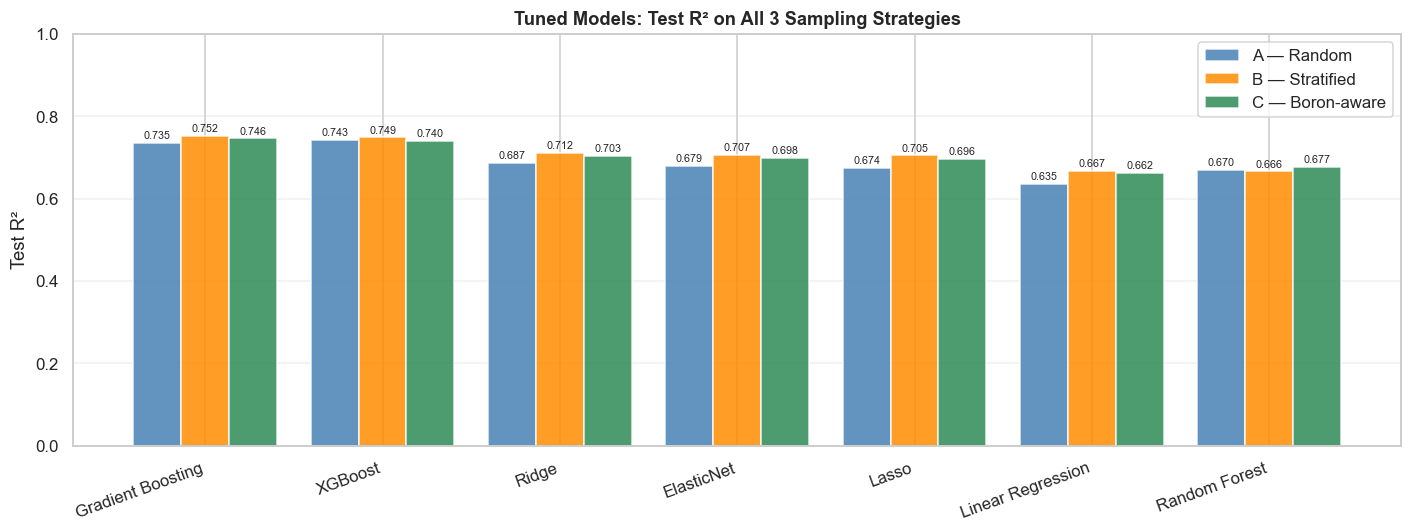

In [14]:
# ── Visualize cross-strategy performance of tuned models ──────────────────────
fig, ax = plt.subplots(figsize=(13, 5))
pivot_tuned_sorted = pivot_tuned.sort_values('B — Stratified', ascending=False)

x = np.arange(len(pivot_tuned_sorted))
width = 0.27
colors_strat = ['steelblue', 'darkorange', 'seagreen']

for i, strat in enumerate(['A — Random', 'B — Stratified', 'C — Boron-aware']):
    vals = pivot_tuned_sorted[strat].values
    bars = ax.bar(x + (i-1)*width, vals, width, label=strat, color=colors_strat[i], alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=7)

ax.set_xticks(x); ax.set_xticklabels(pivot_tuned_sorted.index, rotation=20, ha='right')
ax.set_ylabel('Test R²'); ax.set_ylim(0, 1); ax.legend()
ax.set_title('Tuned Models: Test R² on All 3 Sampling Strategies', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()


---
## Stage 9 — Feature Importance Analysis: All Models

Feature importance is computed using two complementary methods for every model, enabling cross-validation of the results.

**Intrinsic importance** is extracted directly from the fitted model:
- *Linear models:* absolute coefficient magnitudes after scaling. These are comparable across features because RobustScaler normalises each feature to a common range before fitting.
- *Tree models:* mean decrease in impurity (MDI) — the average reduction in node impurity contributed by each feature across all trees. MDI is fast but can be biased toward high-cardinality continuous features.

**Permutation importance** is model-agnostic and applied to all seven models uniformly. Each feature is randomly shuffled on the test set and the resulting drop in R² is recorded. Features whose permutation causes a large performance drop are genuinely important to that model's predictions. This method is unbiased with respect to feature cardinality and data type, making it the more reliable measure for cross-model comparison.

Examining both methods together identifies features that are robustly important (high in both) versus features that appear important in MDI but are actually proxies for correlated variables (high MDI, low permutation importance).

In [15]:
# ── Feature importance extraction ────────────────────────────────────────────
def get_intrinsic_importance(model_name, pipe, feat_names):
    """Get coefficient or MDI importance from fitted pipeline."""
    model = pipe.named_steps['model']
    if hasattr(model, 'coef_'):
        imp = np.abs(model.coef_)
        method = 'Coefficient Magnitude'
    elif hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
        method = 'MDI (Tree Importance)'
    else:
        return None, None
    return pd.Series(imp, index=feat_names).sort_values(ascending=False), method

def get_permutation_importance(pipe, X_te, y_te, feat_names, n_repeats=10, seed=RANDOM_STATE):
    """Compute permutation importance — works for any model."""
    result = sk_permutation_importance(pipe, X_te, y_te, n_repeats=n_repeats,
                                        random_state=seed, scoring='r2')
    imp = pd.Series(result.importances_mean, index=feat_names).sort_values(ascending=False)
    return imp

# Extract for all tuned models
all_intrinsic   = {}
all_permutation = {}

for model_name, pipe in tuned_models:
    print(f"  Computing importance: {model_name}...")
    imp, method = get_intrinsic_importance(model_name, pipe, feat_names)
    if imp is not None:
        all_intrinsic[model_name] = (imp, method)
    
    perm_imp = get_permutation_importance(pipe, X_te_tune, y_te_tune, feat_names)
    all_permutation[model_name] = perm_imp

print("\n✓ Feature importance computed for all models")


  Computing importance: Linear Regression...
  Computing importance: Ridge...
  Computing importance: Lasso...
  Computing importance: ElasticNet...
  Computing importance: Random Forest...
  Computing importance: Gradient Boosting...
  Computing importance: XGBoost...

✓ Feature importance computed for all models


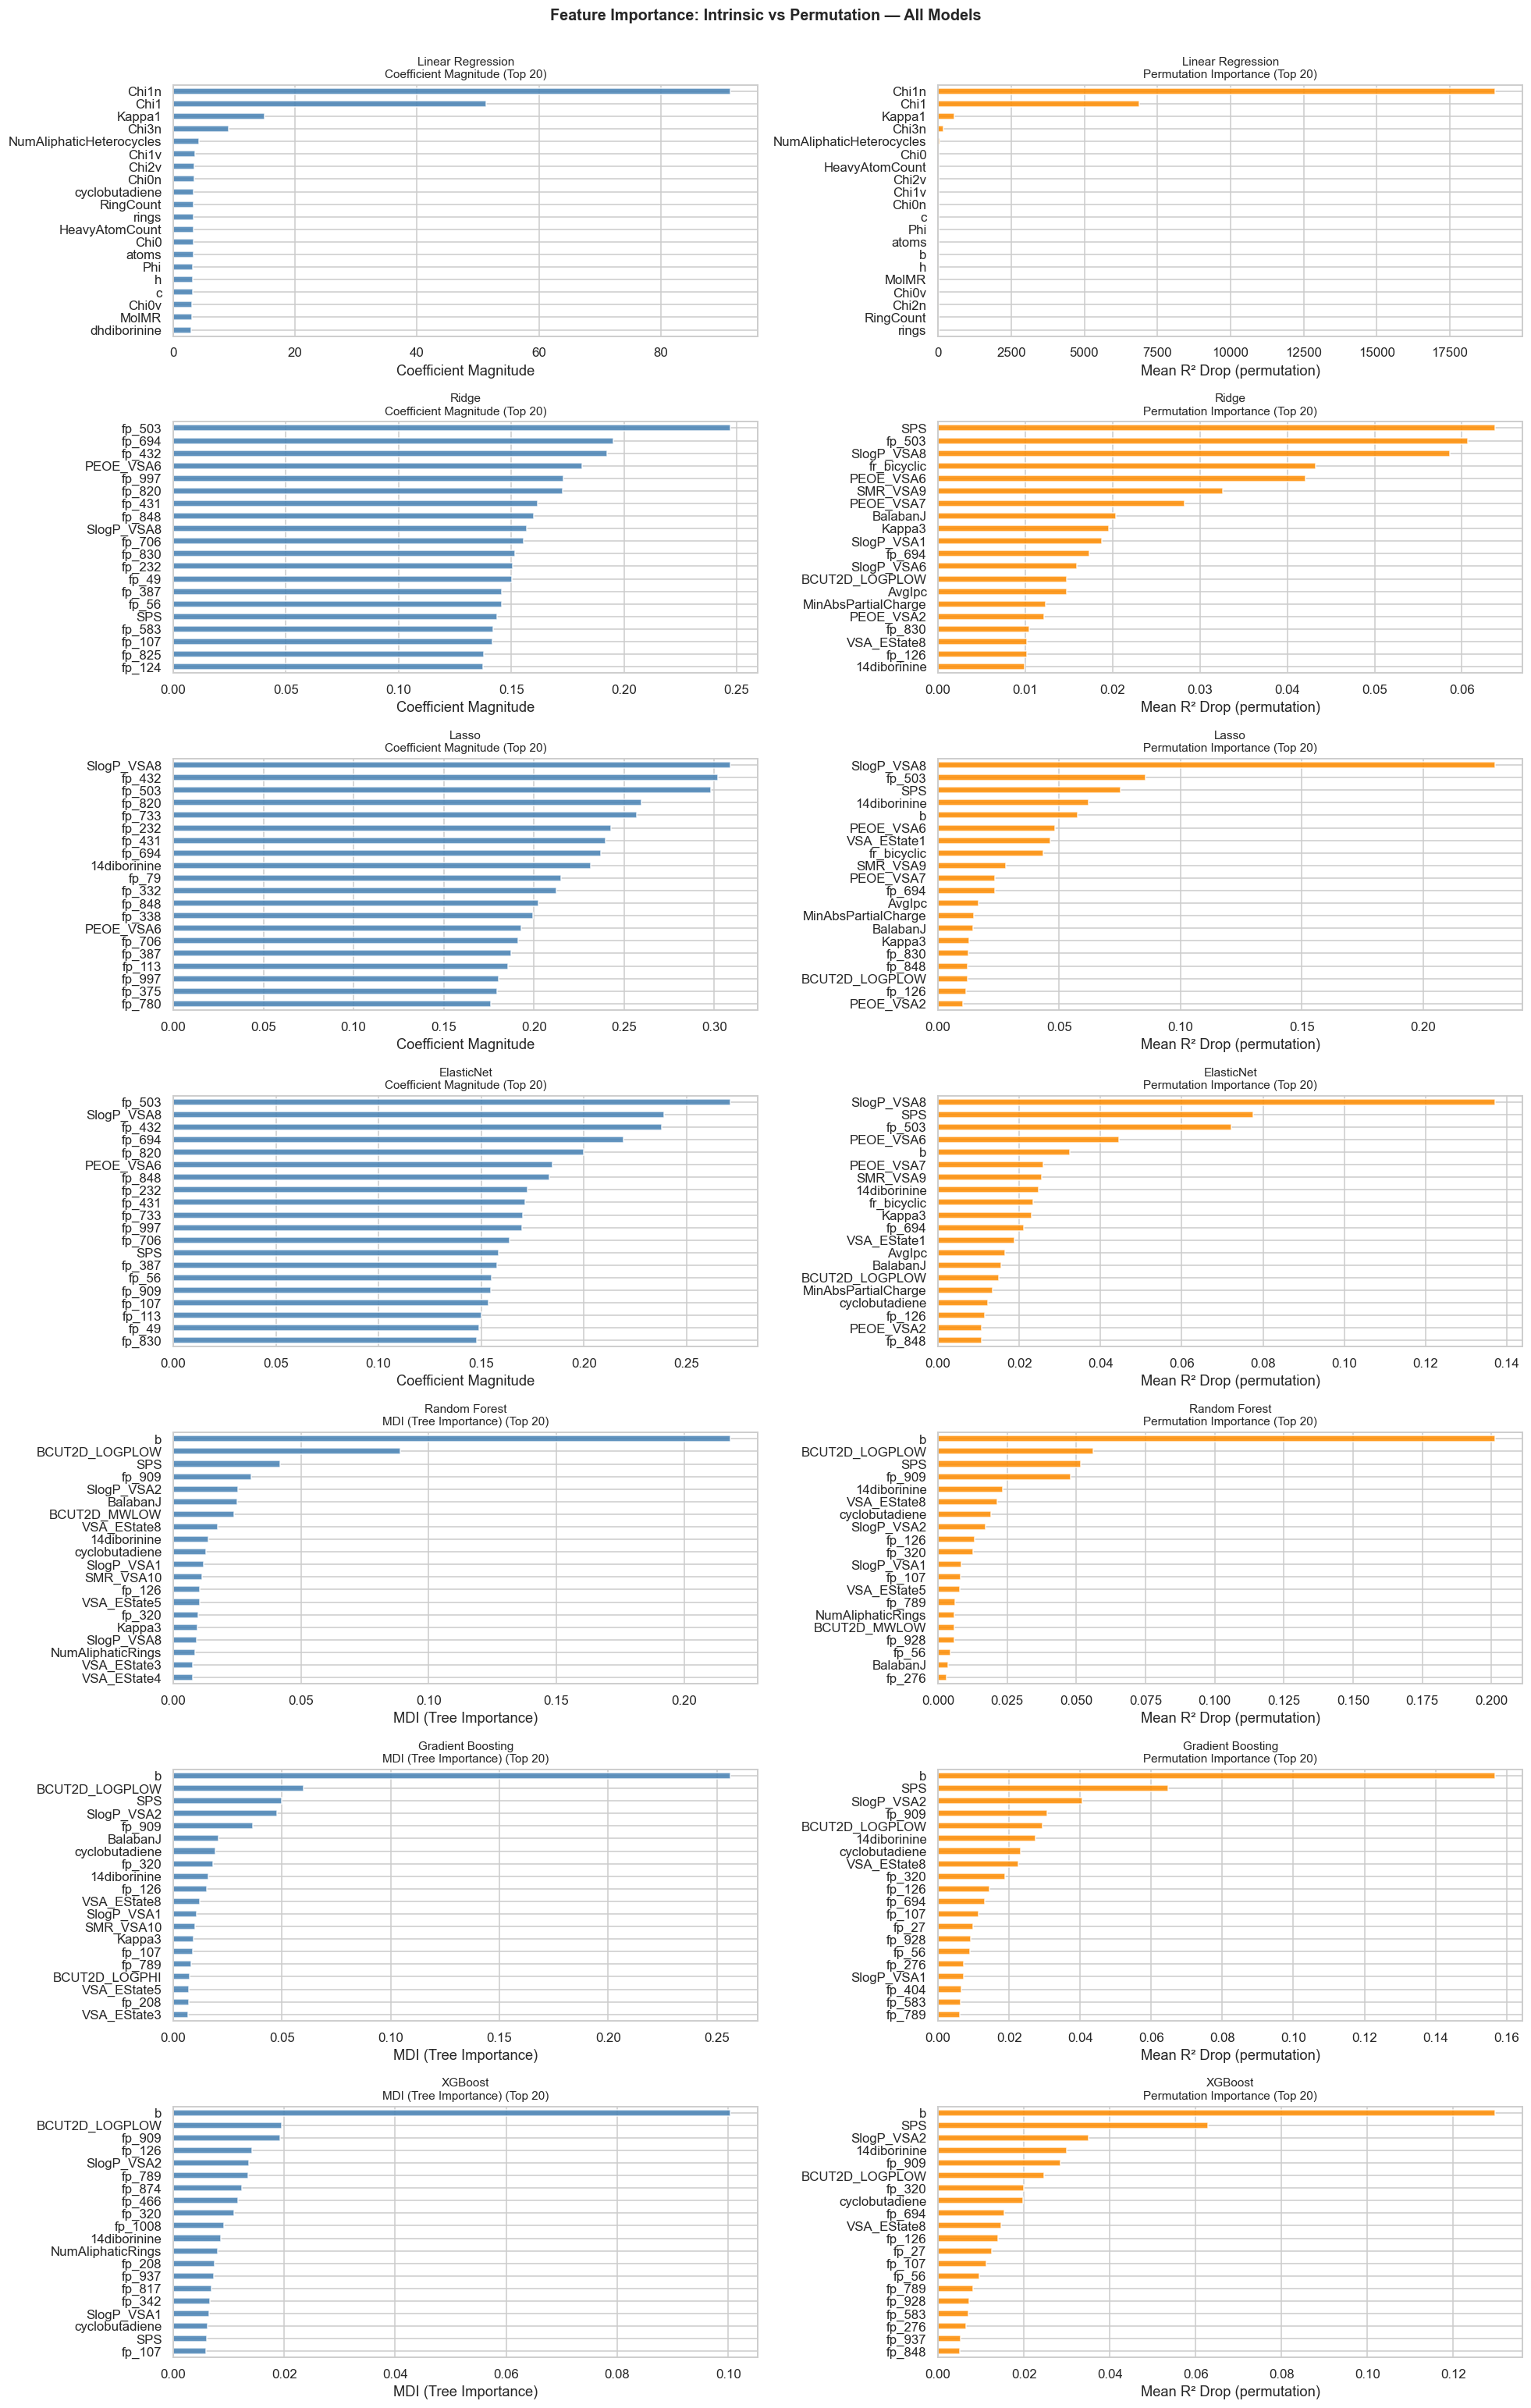

In [16]:
# ── Plot top-20 intrinsic + permutation importance side-by-side for each model ─
n_models = len(tuned_models)
fig, axes = plt.subplots(n_models, 2, figsize=(18, 4*n_models))
if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, _) in enumerate(tuned_models):
    # Intrinsic
    ax_l = axes[idx, 0]
    if model_name in all_intrinsic:
        imp, method = all_intrinsic[model_name]
        top20 = imp.head(20).sort_values()
        top20.plot(kind='barh', ax=ax_l, color='steelblue', alpha=0.85)
        ax_l.set_title(f'{model_name}\n{method} (Top 20)', fontsize=10)
        ax_l.set_xlabel(method)
    
    # Permutation
    ax_r = axes[idx, 1]
    perm = all_permutation[model_name].head(20).sort_values()
    perm.plot(kind='barh', ax=ax_r, color='darkorange', alpha=0.85)
    ax_r.set_title(f'{model_name}\nPermutation Importance (Top 20)', fontsize=10)
    ax_r.set_xlabel('Mean R² Drop (permutation)')

plt.suptitle('Feature Importance: Intrinsic vs Permutation — All Models', fontsize=13, fontweight='bold', y=1.001)
plt.tight_layout(); plt.show()


In [17]:
# ── Print top 10 features for each model ─────────────────────────────────────
print("TOP 10 FEATURES BY PERMUTATION IMPORTANCE — ALL MODELS")
print("="*70)
for model_name, _ in tuned_models:
    perm = all_permutation[model_name]
    print(f"\n{model_name}:")
    for rank, (feat, val) in enumerate(perm.head(10).items(), 1):
        feat_type = 'fingerprint' if feat.startswith('fp_') else 'descriptor'
        print(f"  {rank:2d}. {feat:<40s} {val:+.5f}  [{feat_type}]")


TOP 10 FEATURES BY PERMUTATION IMPORTANCE — ALL MODELS

Linear Regression:
   1. Chi1n                                    +19038.41422  [descriptor]
   2. Chi1                                     +6884.28431  [descriptor]
   3. Kappa1                                   +550.52424  [descriptor]
   4. Chi3n                                    +191.35988  [descriptor]
   5. NumAliphaticHeterocycles                 +53.57317  [descriptor]
   6. Chi0                                     +33.08628  [descriptor]
   7. HeavyAtomCount                           +30.84830  [descriptor]
   8. Chi2v                                    +29.42456  [descriptor]
   9. Chi1v                                    +29.28810  [descriptor]
  10. Chi0n                                    +27.40418  [descriptor]

Ridge:
   1. SPS                                      +0.06378  [descriptor]
   2. fp_503                                   +0.06064  [fingerprint]
   3. SlogP_VSA8                               +0.05860  [d

---
## Stage 10 — Boron-Only Controlled Experiment

All seven models are retrained exclusively on boron-containing molecules, sampled from the full dataset and stratified across the gap distribution. This is the first of two controlled boron experiments.

**Motivation:** Boron atom count (`b`) emerges as the top-ranked permutation importance feature for all three ensemble models (Random Forest, Gradient Boosting, XGBoost) in Stage 9. Linear models instead rank topological connectivity indices (Chi1n, SlogP_VSA8, SPS) highest, reflecting their sensitivity to multicollinearity rather than true chemical importance. Two competing explanations exist for the boron dominance in ensemble models:

1. Boron genuinely and uniquely determines the HOMO-LUMO gap through its electron-deficient character, making it an irreplaceable structural feature.
2. Boron creates a simple classification problem — boron molecules cluster at lower gap values (mean 4.51 eV vs 5.07 eV for non-boron), so the model is partially separating two sub-populations rather than learning continuous structure-property relationships.

By training on boron-only molecules, we eliminate the boron/non-boron classification component entirely. The model is forced to predict gaps *within* the boron-containing chemical space using only the remaining structural variation — ring topology, nitrogen and sulfur substitution patterns, ring size, and conjugation length. Performance on this subset reveals how much predictive power survives once boron's distinguishing role is removed.

Feature importance from the boron-only models is compared with the full-dataset models in Stage 12.

In [18]:
# ── Boron-ONLY dataset ────────────────────────────────────────────────────────
print("Building boron-ONLY dataset...")
df_boron_only = stratified_gap_sample(df[df['has_boron']].copy(), SAMPLE_N)
print(f"Boron-only molecules: {len(df_boron_only):,}  "
      f"gap: μ={df_boron_only[TARGET_COL].mean():.3f}  σ={df_boron_only[TARGET_COL].std():.3f}")

X_bo, y_bo = build_features(df_boron_only)
X_tr_bo, X_te_bo, y_tr_bo, y_te_bo, df_tr_bo, df_te_bo = scaffold_split(df_boron_only, X_bo, y_bo)


Building boron-ONLY dataset...
Boron-only molecules: 5,000  gap: μ=4.507  σ=0.560
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.4% (handled by median imputation in pipeline)
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓


In [19]:
# ── Train ALL 7 models on boron-only data ────────────────────────────────────
print("\nTraining ALL models on BORON-ONLY data:")
print("="*65)
boron_only_results = []
boron_only_preds   = {}
boron_only_pipes   = {}

for model_name, pipe_tuned in tuned_models:
    # Re-instantiate model with SAME tuned hyperparameters but fresh fit
    inner_model = pipe_tuned.named_steps['model']
    # Clone with same parameters
    new_pipe = make_pipeline(type(inner_model)(**inner_model.get_params()))
    new_pipe.fit(X_tr_bo, y_tr_bo)
    pred = new_pipe.predict(X_te_bo)
    r2   = r2_score(y_te_bo, pred)
    mae  = mean_absolute_error(y_te_bo, pred)
    rmse = np.sqrt(mean_squared_error(y_te_bo, pred))
    
    print(f"  {model_name:<25s}  R²={r2:.4f}  MAE={mae:.4f}")
    boron_only_results.append({'Model': model_name, 'Test R²': r2, 'MAE': mae, 'RMSE': rmse})
    boron_only_preds[model_name] = pred
    boron_only_pipes[model_name] = new_pipe

# Feature importance on boron-only
bo_intrinsic = {}
for model_name, pipe in boron_only_pipes.items():
    imp, method = get_intrinsic_importance(model_name, pipe, feat_names)
    if imp is not None:
        bo_intrinsic[model_name] = (imp, method)

bo_df = pd.DataFrame(boron_only_results)
display(bo_df.round(4))



Training ALL models on BORON-ONLY data:
  Linear Regression          R²=0.4818  MAE=0.3103
  Ridge                      R²=0.6135  MAE=0.2752
  Lasso                      R²=0.6065  MAE=0.2788
  ElasticNet                 R²=0.6093  MAE=0.2773
  Random Forest              R²=0.5579  MAE=0.2951
  Gradient Boosting          R²=0.6350  MAE=0.2614
  XGBoost                    R²=0.6319  MAE=0.2623


Model  Test R²     MAE    RMSE
0  Linear Regression   0.4818  0.3103  0.4156
1              Ridge   0.6135  0.2752  0.3589
2              Lasso   0.6065  0.2788  0.3622
3         ElasticNet   0.6093  0.2773  0.3609
4      Random Forest   0.5579  0.2951  0.3839
5  Gradient Boosting   0.6350  0.2614  0.3488
6            XGBoost   0.6319  0.2623  0.3503

---
## Stage 11 — Boron-Free Controlled Experiment

All seven models are retrained exclusively on non-boron-containing molecules, providing the second half of the controlled boron investigation. The boron-free dataset is drawn from the full 52,000-molecule set and stratified across the gap distribution, producing a 5,000-molecule training set representing the pure carbon/nitrogen/oxygen/sulfur chemical space. The boron-free subset has a mean gap of 5.07 eV and standard deviation of 0.70 eV.

**What this tests:** Without boron, the model has no access to the dominant predictor identified in Stage 9 for ensemble models. Counterintuitively, boron-free models outperform the full-dataset models for every model family (Gradient Boosting: R² = 0.798 boron-free vs 0.752 on all molecules; XGBoost: 0.792 vs 0.749; Linear Regression: 0.735 vs 0.667). This reveals that boron's presence in the mixed dataset actually introduces distributional complexity — the bimodal gap structure it creates forces models to solve a harder two-population problem. Within the pure carbon/nitrogen chemical space, the gap is more uniformly governed by ring topology and conjugation length, which are well-captured by the structural descriptors and Morgan fingerprints.

**Feature importance shift:** In the absence of boron, other features absorb the predictive weight. The expected replacements are ring topology descriptors (number of rings, aromatic ring fraction), conjugation-related descriptors such as SPS and SlogP_VSA8, and specific Morgan fingerprint bits encoding nitrogen-containing ring environments. Observing which features rise in importance provides mechanistic insight into the electronic structure of the non-boron chemical space.

In [20]:
# ── Boron-FREE dataset ────────────────────────────────────────────────────────
print("Building boron-FREE dataset...")
df_noboron = stratified_gap_sample(df[~df['has_boron']].copy(), SAMPLE_N)
print(f"Boron-free molecules: {len(df_noboron):,}  "
      f"gap: μ={df_noboron[TARGET_COL].mean():.3f}  σ={df_noboron[TARGET_COL].std():.3f}")

X_nob, y_nob = build_features(df_noboron)
X_tr_nob, X_te_nob, y_tr_nob, y_te_nob, df_tr_nob, df_te_nob = scaffold_split(df_noboron, X_nob, y_nob)


Building boron-FREE dataset...
Boron-free molecules: 5,000  gap: μ=5.068  σ=0.696
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.5% (handled by median imputation in pipeline)
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓


In [21]:
# ── Train ALL 7 models on boron-free data ────────────────────────────────────
print("\nTraining ALL models on BORON-FREE data:")
print("="*65)
boron_free_results = []
boron_free_pipes   = {}

for model_name, pipe_tuned in tuned_models:
    inner_model = pipe_tuned.named_steps['model']
    new_pipe = make_pipeline(type(inner_model)(**inner_model.get_params()))
    new_pipe.fit(X_tr_nob, y_tr_nob)
    pred = new_pipe.predict(X_te_nob)
    r2   = r2_score(y_te_nob, pred)
    mae  = mean_absolute_error(y_te_nob, pred)
    rmse = np.sqrt(mean_squared_error(y_te_nob, pred))
    
    print(f"  {model_name:<25s}  R²={r2:.4f}  MAE={mae:.4f}")
    boron_free_results.append({'Model': model_name, 'Test R²': r2, 'MAE': mae, 'RMSE': rmse})
    boron_free_pipes[model_name] = new_pipe

bf_df = pd.DataFrame(boron_free_results)
display(bf_df.round(4))

# Feature importance on boron-free
bf_intrinsic = {}
for model_name, pipe in boron_free_pipes.items():
    imp, method = get_intrinsic_importance(model_name, pipe, feat_names)
    if imp is not None:
        bf_intrinsic[model_name] = (imp, method)



Training ALL models on BORON-FREE data:
  Linear Regression          R²=0.7349  MAE=0.2802
  Ridge                      R²=0.7479  MAE=0.2741
  Lasso                      R²=0.7416  MAE=0.2770
  ElasticNet                 R²=0.7402  MAE=0.2780
  Random Forest              R²=0.7310  MAE=0.2772
  Gradient Boosting          R²=0.7982  MAE=0.2375
  XGBoost                    R²=0.7917  MAE=0.2412


Model  Test R²     MAE    RMSE
0  Linear Regression   0.7349  0.2802  0.3645
1              Ridge   0.7479  0.2741  0.3554
2              Lasso   0.7416  0.2770  0.3599
3         ElasticNet   0.7402  0.2780  0.3609
4      Random Forest   0.7310  0.2772  0.3672
5  Gradient Boosting   0.7982  0.2375  0.3180
6            XGBoost   0.7917  0.2412  0.3231

---
## Stage 12 — Three-Way Boron Comparison

Results from Stages 10 and 11 are compiled alongside the full-dataset (Strategy B) performance into a three-condition comparison table and visualisation for all seven models.

This comparison directly addresses the scientific question posed in Stage 10. The result is striking: **boron-free models consistently outperform both the full-dataset and boron-only models** across all seven model families. Boron-only models show the lowest R² in every case (Gradient Boosting: 0.635, XGBoost: 0.632, Linear Regression: 0.482, Random Forest: 0.558), while boron-free models show the highest (Gradient Boosting: 0.798, XGBoost: 0.792, Linear Regression: 0.735, Random Forest: 0.731). This consistent ordering — boron-free > all molecules > boron-only — indicates that boron molecules are genuinely harder to predict within their own chemical space, and that the mixed-dataset models are solving a more complex two-population problem rather than a clean structure-property regression.

The feature importance rankings under each condition are also compared, showing which descriptors step into the role vacated by boron when it is absent from the training data.

Three-Way Boron Comparison (Test R²):


Model  R² (All+B)  R² (Boron-only)  R² (Boron-free)
5  Gradient Boosting      0.7523           0.6350           0.7982
6            XGBoost      0.7487           0.6319           0.7917
1              Ridge      0.7118           0.6135           0.7479
3         ElasticNet      0.7068           0.6093           0.7402
2              Lasso      0.7050           0.6065           0.7416
0  Linear Regression      0.6673           0.4818           0.7349
4      Random Forest      0.6662           0.5579           0.7310

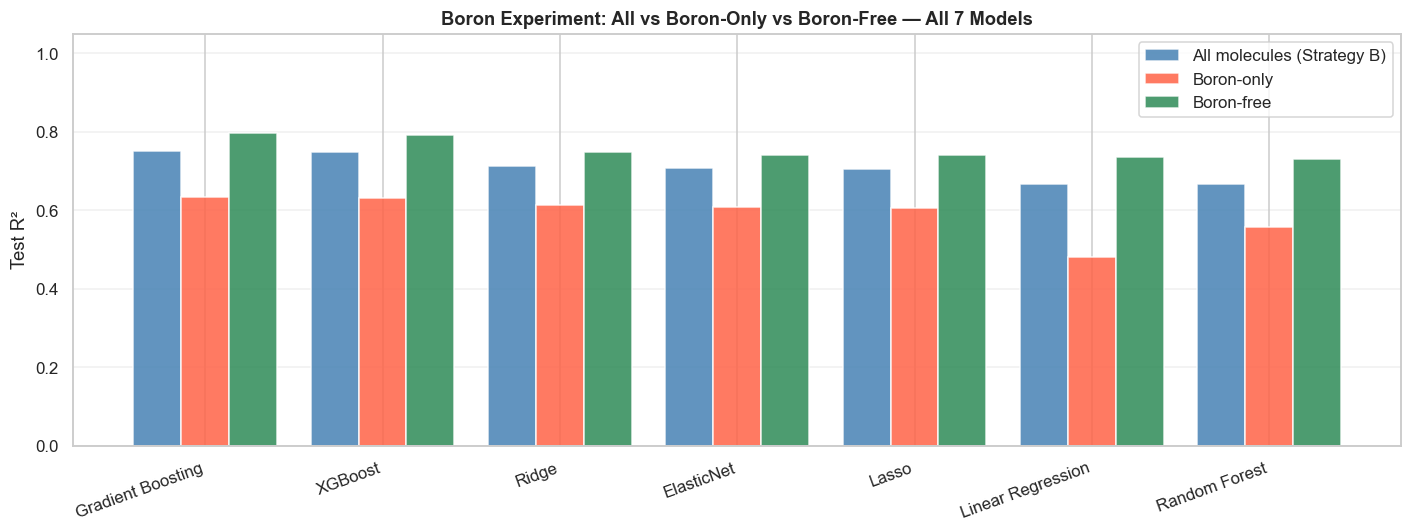


Top feature by condition:
Model                      All molecules                   Boron-only                      Boron-free                    
------------------------------------------------------------------------------------------------------------------------
  Linear Regression        Chi1n                           Chi1n                           Chi1                          
  Ridge                    fp_503                          fp_107                          fp_848                        
  Lasso                    SlogP_VSA8                      fp_375                          fp_848                        
  ElasticNet               fp_503                          fp_56                           fp_848                        
  Random Forest            b                               VSA_EState8                     VSA_EState8                   
  Gradient Boosting        b                               VSA_EState8                     VSA_EState8                  

In [22]:
# ── Three-way boron comparison table ──────────────────────────────────────────
rows = []
for model_name, _ in tuned_models:
    r2_all  = preds_B[model_name] ; r2_all_val = r2_score(y_te_tune, r2_all)
    r2_bo   = next(r['Test R²'] for r in boron_only_results if r['Model']==model_name)
    r2_bf   = next(r['Test R²'] for r in boron_free_results if r['Model']==model_name)
    rows.append({'Model': model_name, 'R² (All+B)': r2_all_val, 'R² (Boron-only)': r2_bo, 'R² (Boron-free)': r2_bf})

comparison_df = pd.DataFrame(rows).sort_values('R² (All+B)', ascending=False)
print("Three-Way Boron Comparison (Test R²):")
display(comparison_df.round(4))

# Visualise
fig, ax = plt.subplots(figsize=(13, 5))
x = np.arange(len(comparison_df))
w = 0.27
for i, (col, color, label) in enumerate([
    ('R² (All+B)',     'steelblue',   'All molecules (Strategy B)'),
    ('R² (Boron-only)','tomato',       'Boron-only'),
    ('R² (Boron-free)','seagreen',     'Boron-free'),
]):
    ax.bar(x + (i-1)*w, comparison_df[col], w, label=label, color=color, alpha=0.85)

ax.set_xticks(x); ax.set_xticklabels(comparison_df['Model'], rotation=20, ha='right')
ax.set_ylabel('Test R²'); ax.set_ylim(0, 1.05); ax.legend()
ax.set_title('Boron Experiment: All vs Boron-Only vs Boron-Free — All 7 Models', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# Feature importance: boron rank in each condition
print("\nTop feature by condition:")
print(f"{'Model':<25s}  {'All molecules':<30s}  {'Boron-only':<30s}  {'Boron-free':<30s}")
print("-"*120)
for model_name, _ in tuned_models:
    # All molecules
    top_all = all_intrinsic[model_name][0].index[0] if model_name in all_intrinsic else 'N/A'
    
    # Boron-only
    top_bo = bo_intrinsic[model_name][0].index[0] if model_name in bo_intrinsic else 'N/A'
    
    # Boron-free
    top_bf = bf_intrinsic[model_name][0].index[0] if model_name in bf_intrinsic else 'N/A'
    
    print(f"  {model_name:<23s}  {top_all:<30s}  {top_bo:<30s}  {top_bf:<30s}")


---
## Stage 13 — Train vs. Test Scatter Plots

Actual vs. predicted scatter plots are generated for all seven tuned models on Strategy B, showing both the training set and test set predictions side by side. The diagonal (y = x) represents perfect prediction; deviation from this line represents model error.

These plots serve two diagnostic purposes. First, the gap between train and test R² directly quantifies overfitting — a large gap indicates the model has memorised training patterns that do not transfer to new scaffolds. Second, systematic deviations from the diagonal (fan-shaped scatter, curvature, or regional bias) reveal structural limitations of specific model families — for example, linear models may show systematic underprediction at extreme gap values where nonlinearity dominates.

The overfit gap (Train R² − Test R²) is reported numerically for each model, allowing direct comparison of regularisation effectiveness across model families.

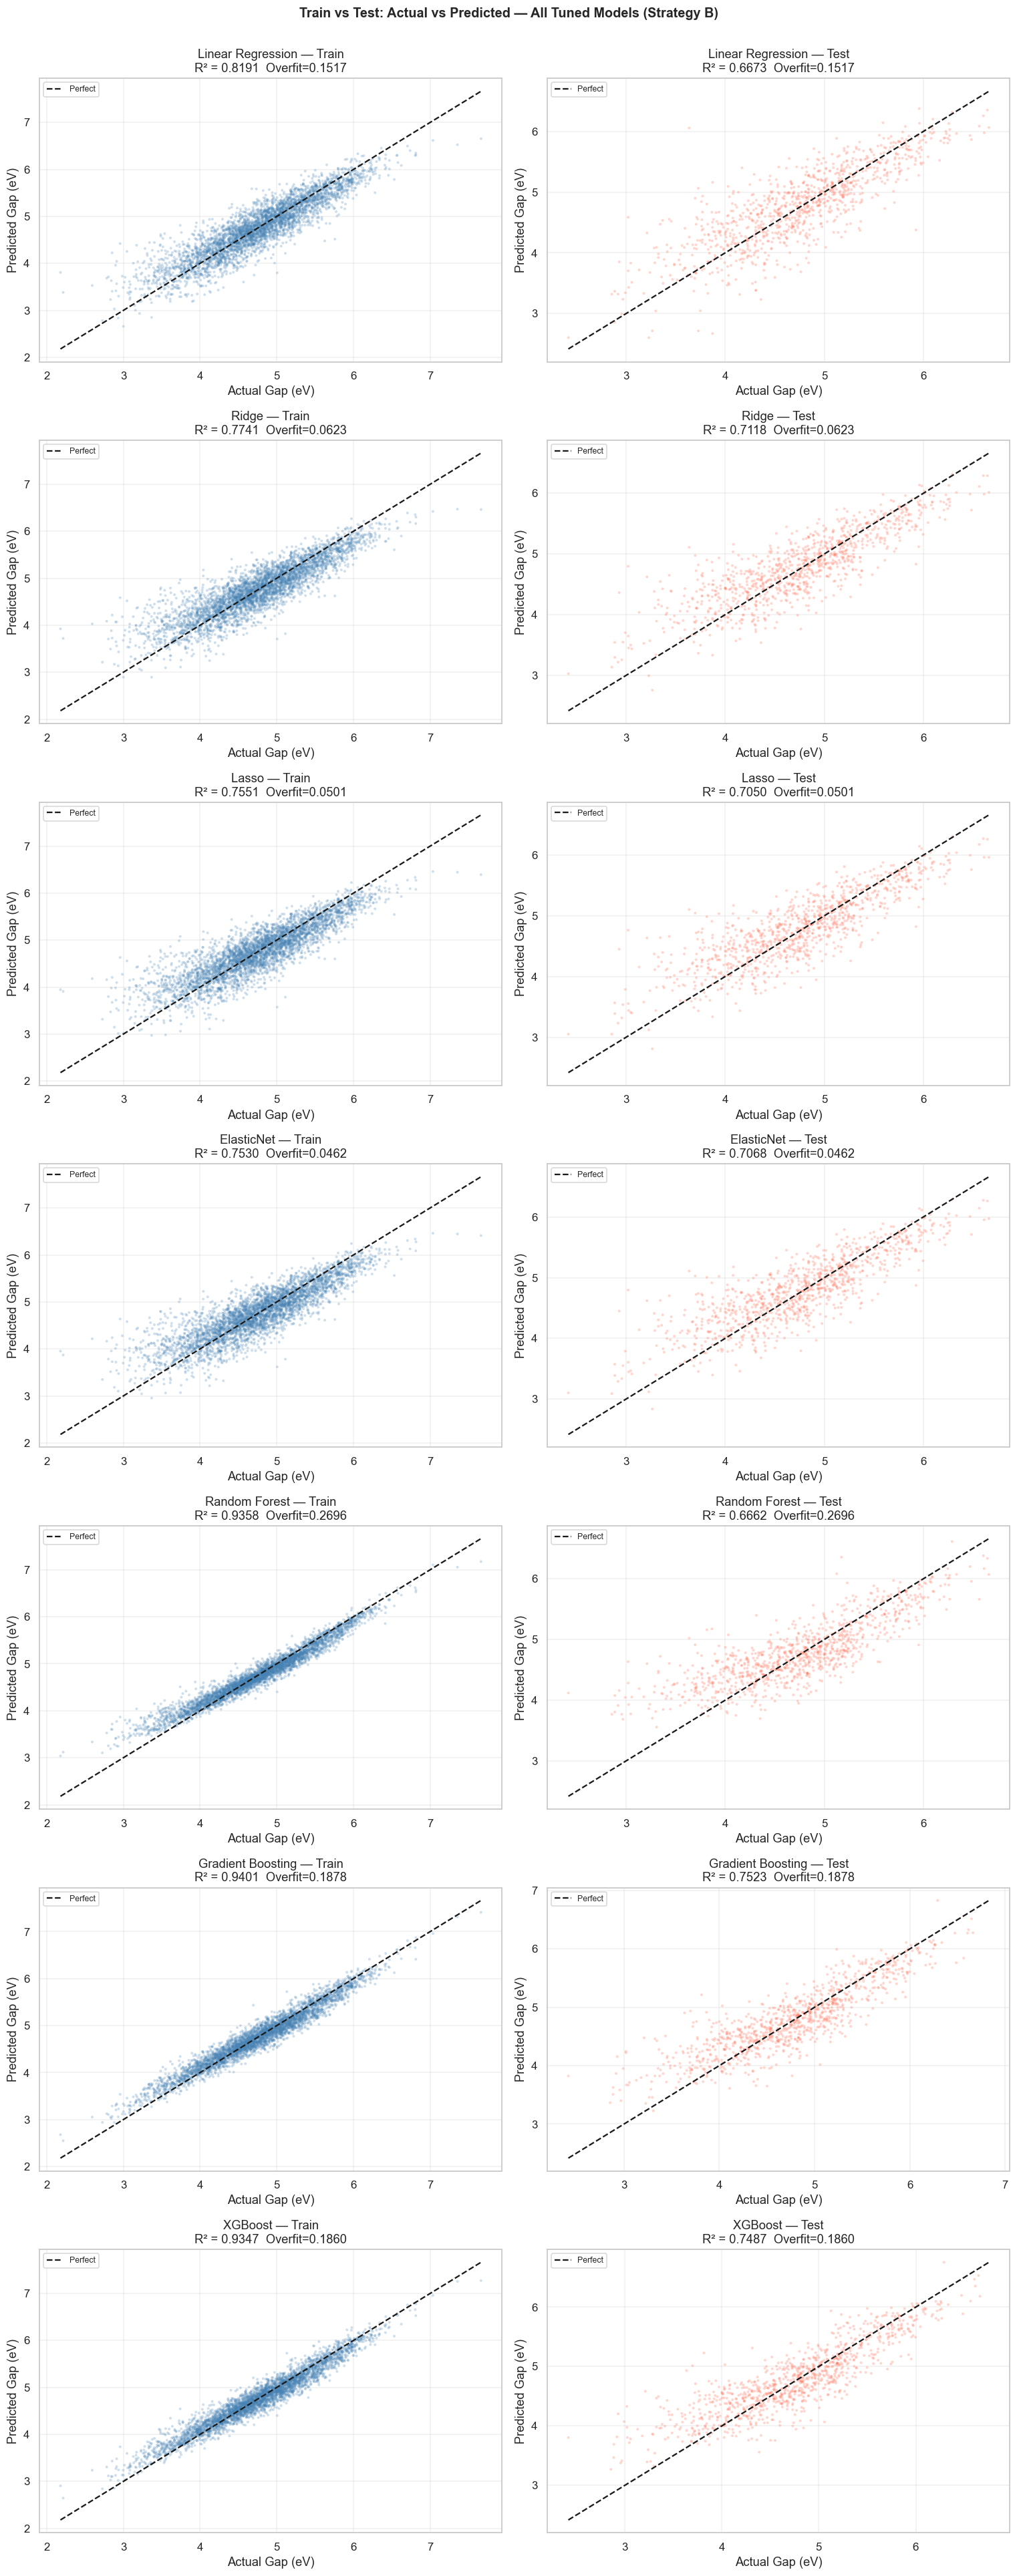

In [23]:
# ── Train vs Test scatter — all 7 tuned models ────────────────────────────────
n_m = len(tuned_models)
fig, axes = plt.subplots(n_m, 2, figsize=(14, 5*n_m))
if n_m == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, pipe) in enumerate(tuned_models):
    tr_pred = pipe.predict(X_tr_tune)
    te_pred = preds_B[model_name]
    
    r2_tr = r2_score(y_tr_tune, tr_pred)
    r2_te = r2_score(y_te_tune, te_pred)
    
    for ax, y_true, y_pred, split, r2, color in [
        (axes[idx,0], y_tr_tune, tr_pred, 'Train', r2_tr, 'steelblue'),
        (axes[idx,1], y_te_tune, te_pred, 'Test',  r2_te, 'tomato'),
    ]:
        ax.scatter(y_true, y_pred, alpha=0.25, s=7, color=color, edgecolors='none')
        mn = min(y_true.min(), y_pred.min())
        mx = max(y_true.max(), y_pred.max())
        ax.plot([mn,mx],[mn,mx],'k--',linewidth=1.5,label='Perfect')
        ax.set_xlabel('Actual Gap (eV)'); ax.set_ylabel('Predicted Gap (eV)')
        ax.set_title(f'{model_name} — {split}\nR² = {r2:.4f}  Overfit={r2_tr-r2_te:.4f}')
        ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

plt.suptitle('Train vs Test: Actual vs Predicted — All Tuned Models (Strategy B)', 
             fontsize=13, fontweight='bold', y=1.001)
plt.tight_layout(); plt.show()


---
## Stage 14 — Structural Outlier Analysis

The 10 best-predicted and 10 worst-predicted molecules are identified from the Strategy B test set for each of the seven models. This analysis connects quantitative prediction errors back to molecular structure, enabling chemical interpretation of model limitations.

**Three levels of analysis are applied:**

1. **Structural visualisation** — Molecular structures are rendered using RDKit's grid image function. Visual inspection reveals whether poorly predicted molecules share common structural motifs (e.g., large fused systems, five-membered ring insertions, unusual heteroatom combinations) absent or rare in well-predicted molecules.

2. **Morgan fingerprint comparison** — Mean fingerprint bit activation vectors are computed separately for the best-predicted and worst-predicted sets. Bits that are systematically more active in poorly predicted molecules represent structural fragments that the model has not learned to associate with gap values, either because they were rare in the training set or because they introduce genuinely novel electronic environments.

3. **Training-set rarity check** — For each bit that distinguishes poorly predicted molecules, its frequency in the training set fingerprint matrix is computed. Bits appearing in fewer than 5% of training molecules are flagged as structurally novel — the model has insufficient training examples to learn their contribution to the gap.

SMILES strings are retrieved using the aligned `df_te_B` dataframe returned by `scaffold_split()`, ensuring correct molecule-to-prediction correspondence without index remapping errors.


✅ Linear Regression — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


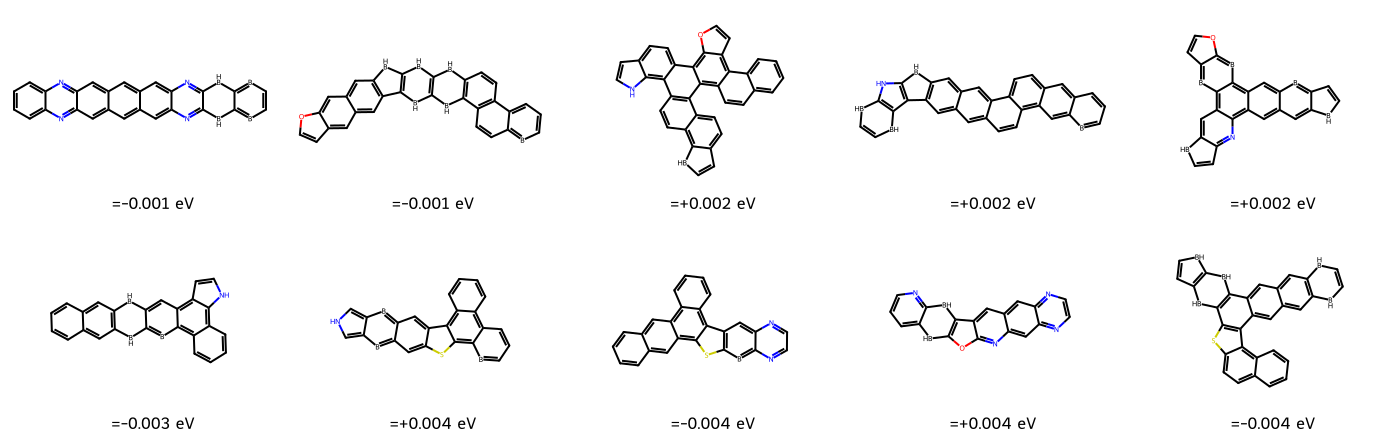


❌ Linear Regression — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


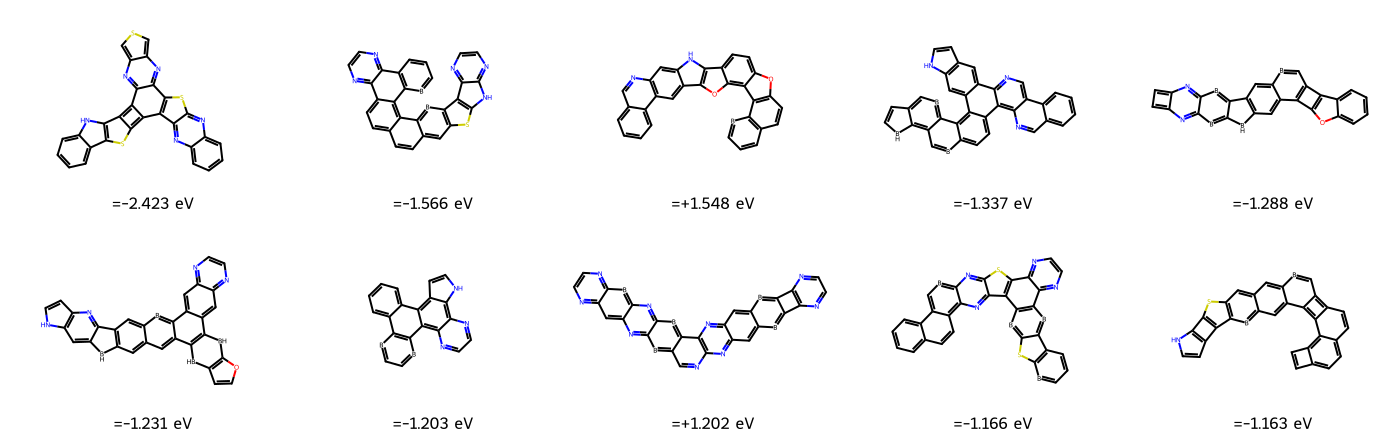


✅ Ridge — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


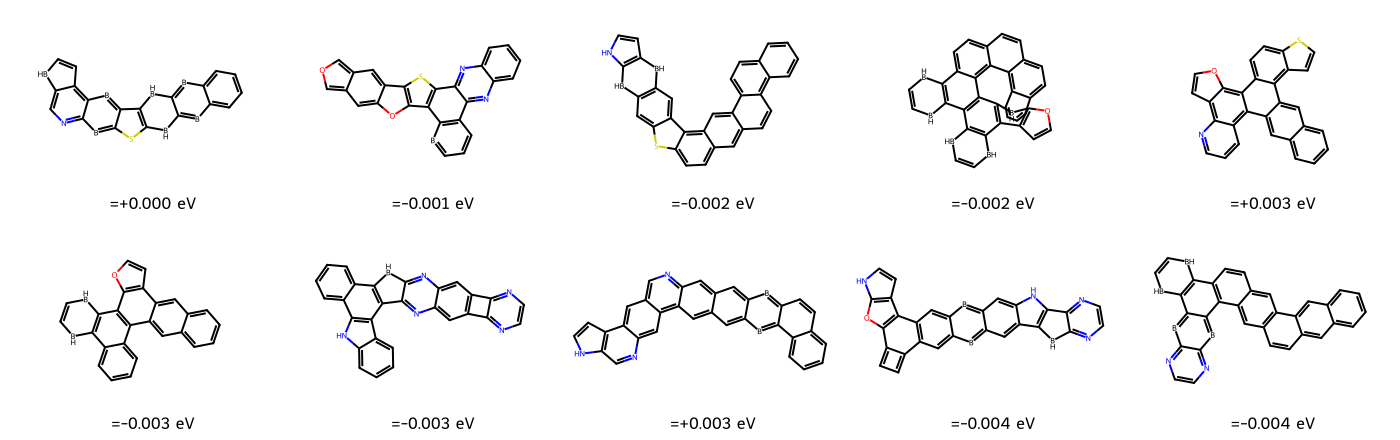


❌ Ridge — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


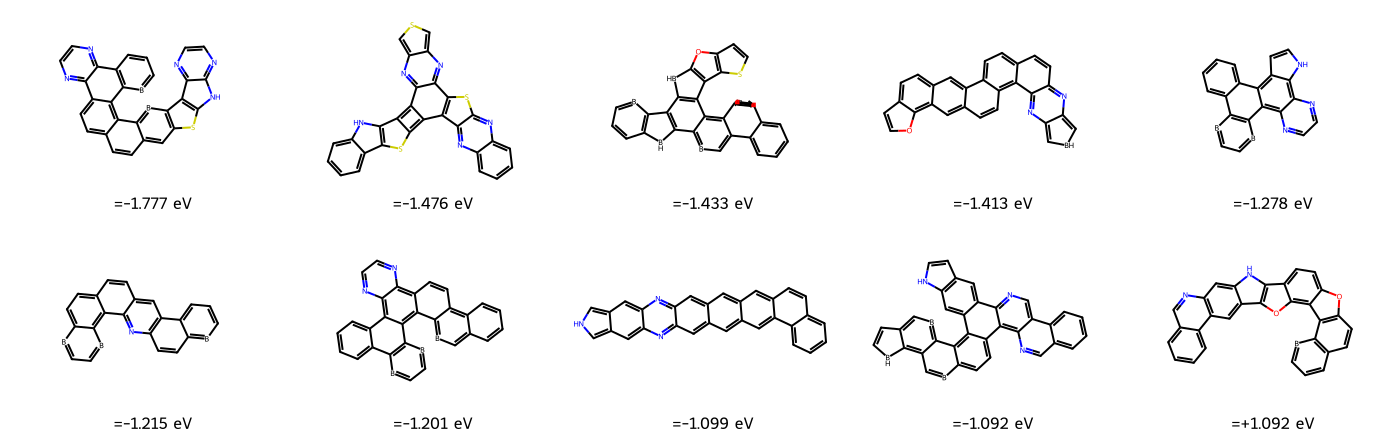


✅ Lasso — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


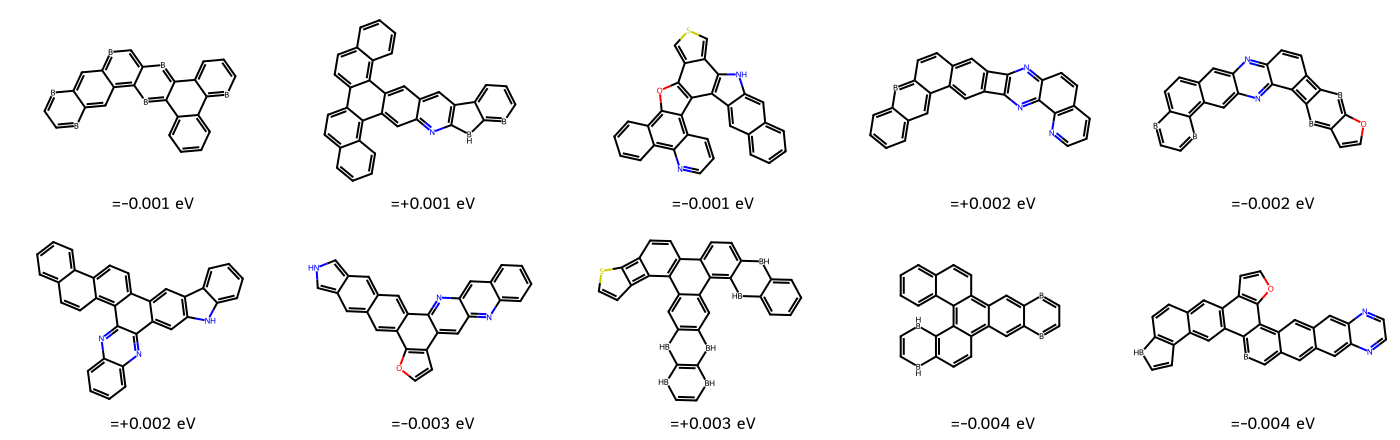


❌ Lasso — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


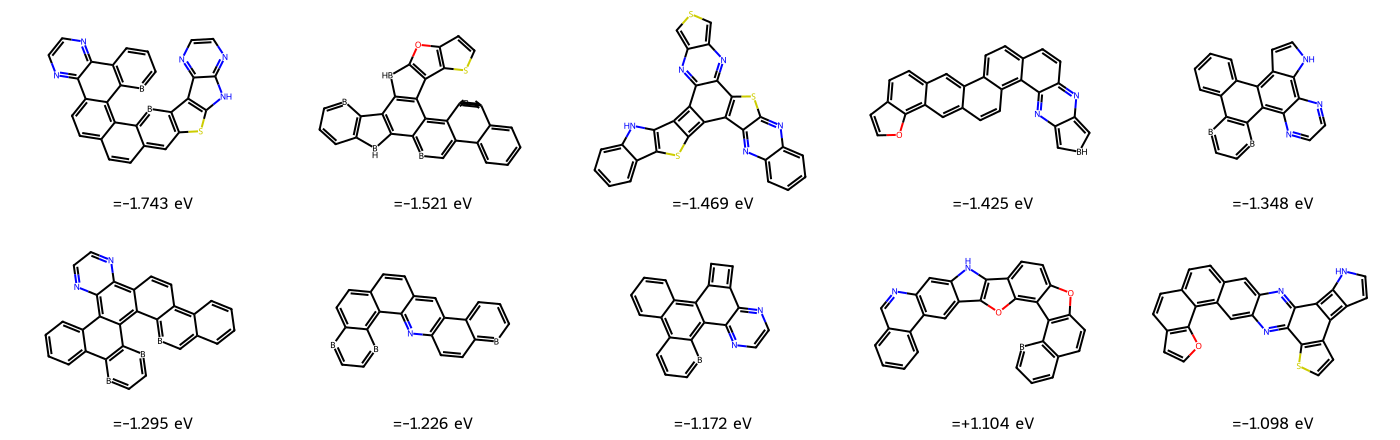


✅ ElasticNet — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


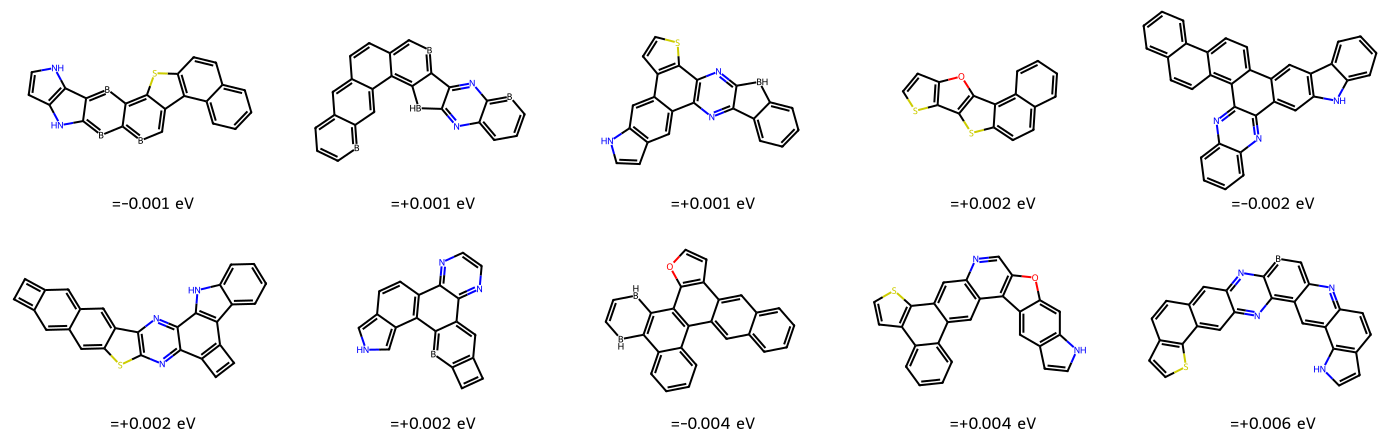


❌ ElasticNet — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


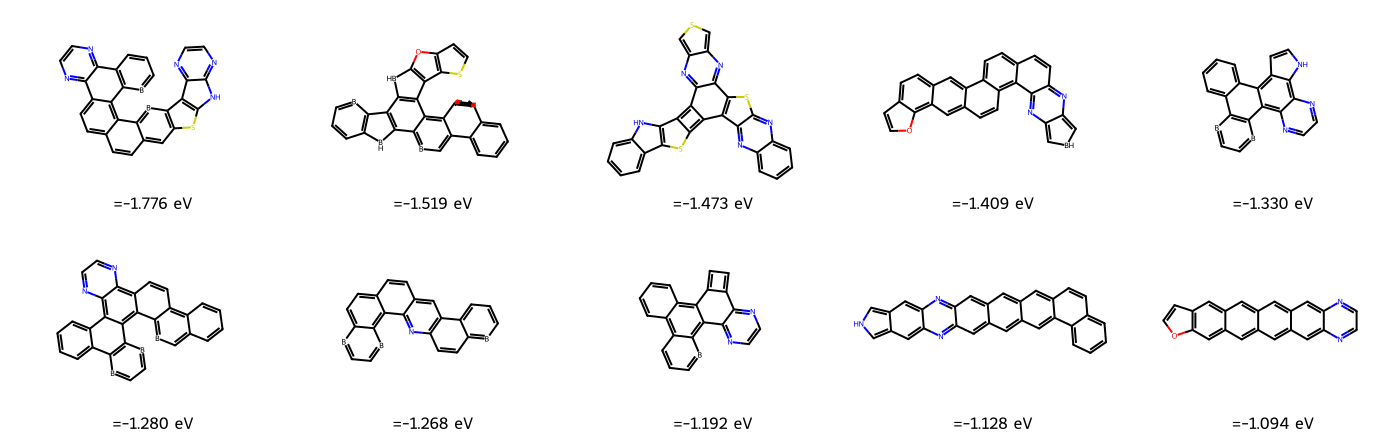


✅ Random Forest — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


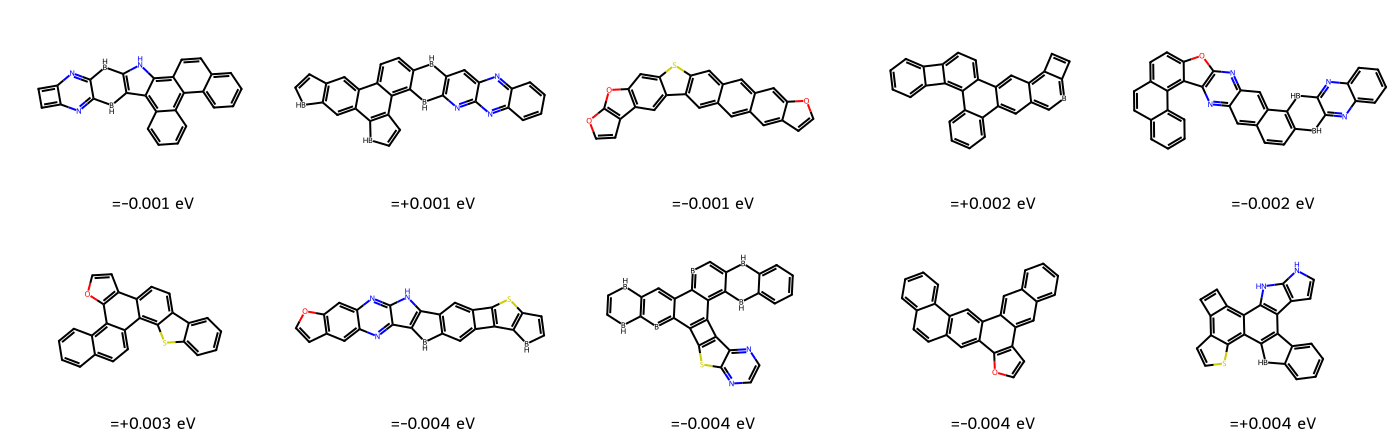


❌ Random Forest — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


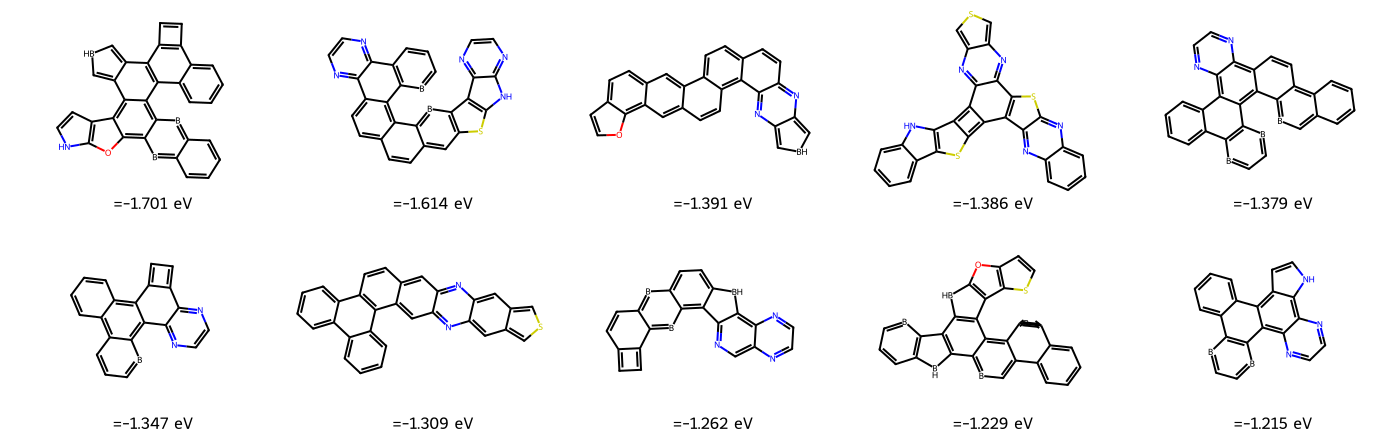


✅ Gradient Boosting — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


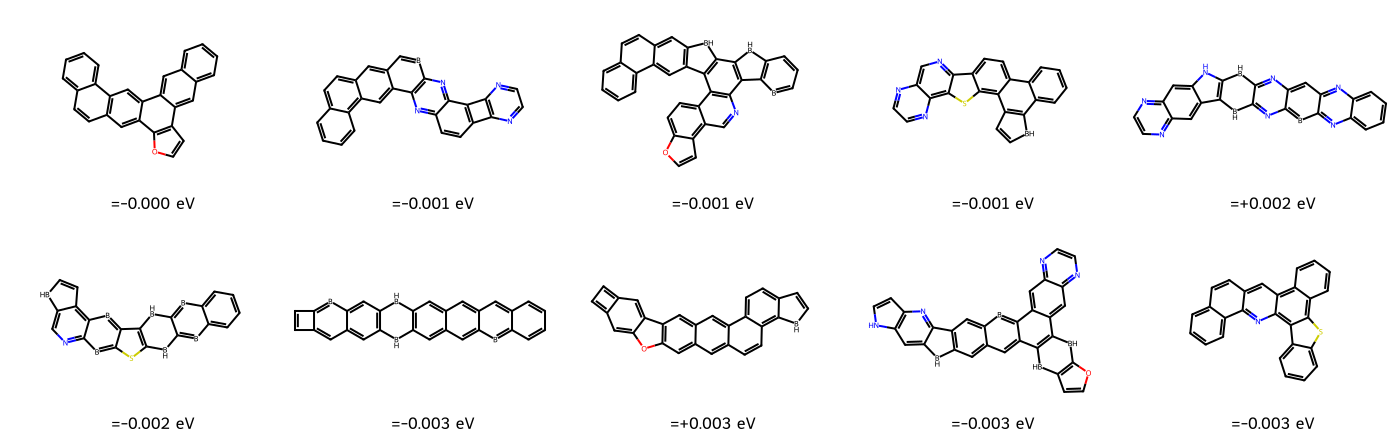


❌ Gradient Boosting — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


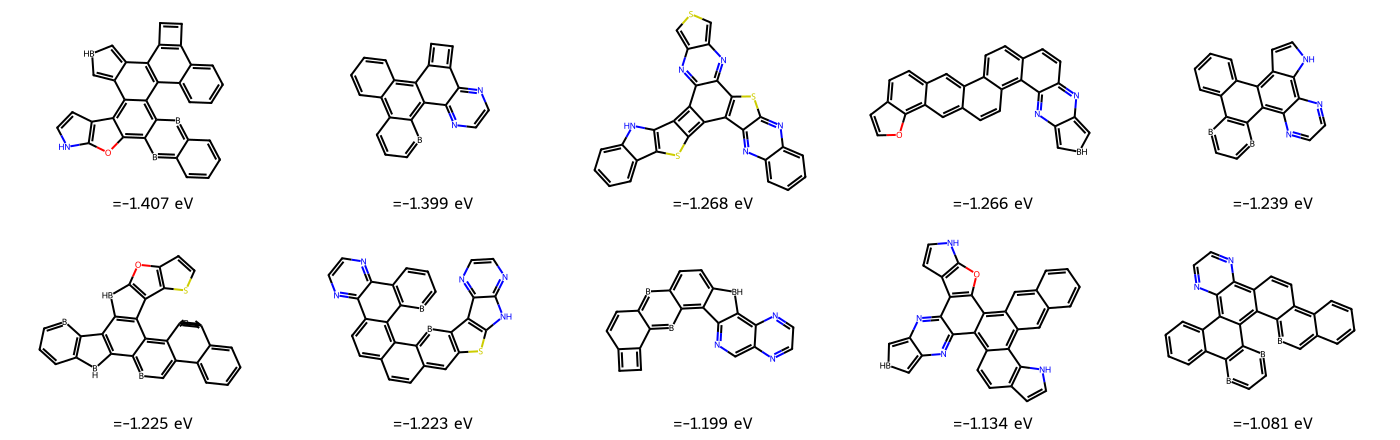


✅ XGBoost — 10 Best Predicted (lowest |error|)
────────────────────────────────────────────────────────────────────────────────


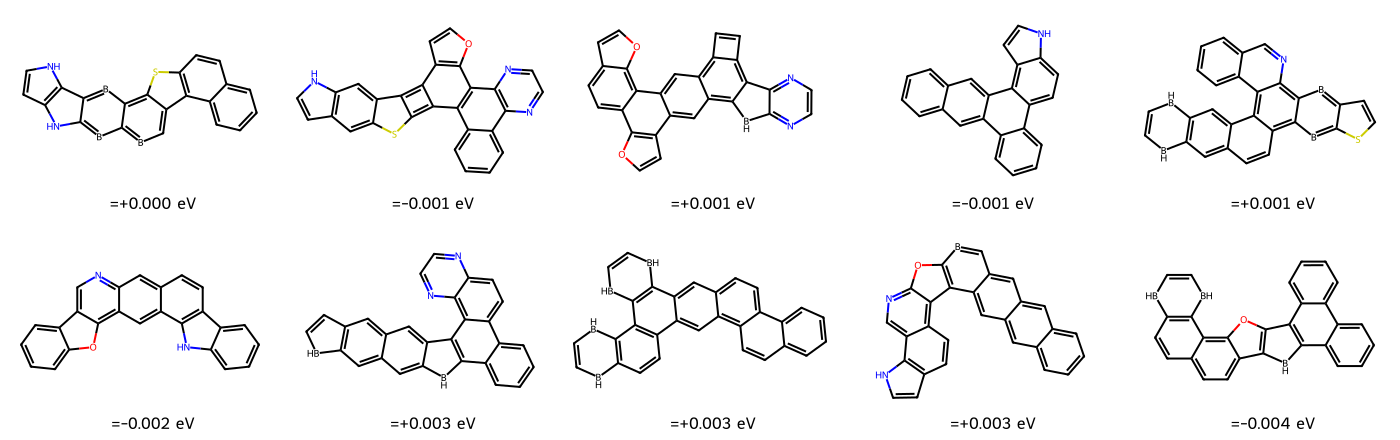


❌ XGBoost — 10 Worst Predicted (highest |error|)
────────────────────────────────────────────────────────────────────────────────


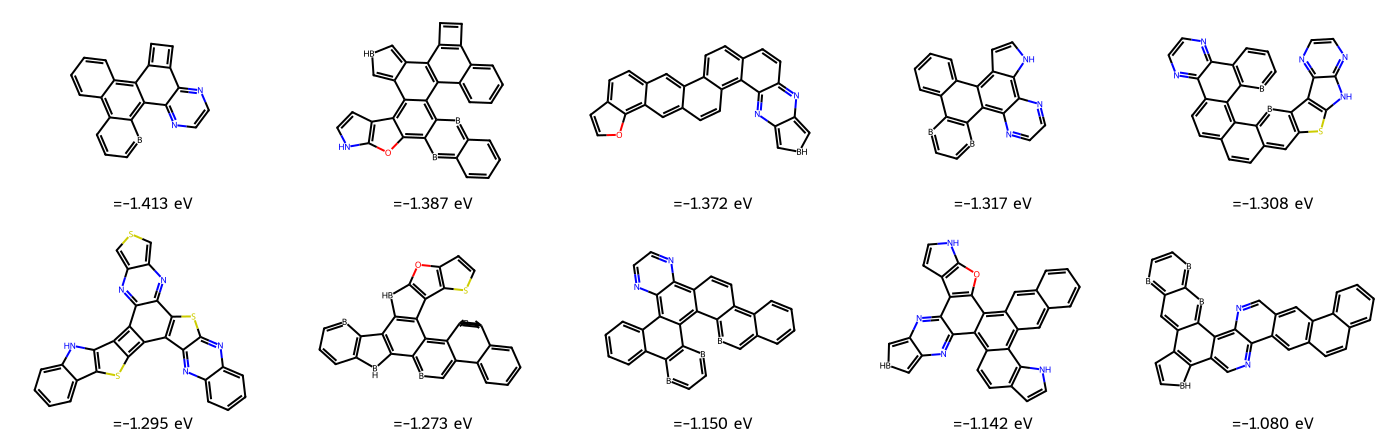

In [24]:
# ── Outlier identification for EVERY model ───────────────────────────────────
def get_outliers(y_true, y_pred, df_test, n=10):
    """Return best/worst predicted molecules with correct SMILES lookup."""
    residuals = np.abs(y_true - y_pred)
    res_df = pd.DataFrame({
        'actual': y_true, 'predicted': y_pred,
        'abs_error': residuals, 'error': y_true - y_pred,
        SMILES_COL: df_test[SMILES_COL].values
    })
    # df_test is already aligned (both reset_index(drop=True)) — no mapping needed
    best  = res_df.nsmallest(n, 'abs_error')
    worst = res_df.nlargest(n, 'abs_error')
    return best, worst

outlier_data = {}
for model_name, _ in tuned_models:
    best, worst = get_outliers(y_te_tune, preds_B[model_name], df_te_B)
    outlier_data[model_name] = {'best': best, 'worst': worst}

# Visualise structures for each model
def draw_grid(smiles_list, labels, title, n_cols=5):
    """Draw molecular structures grid."""
    mols, valid_labels = [], []
    for smi, lab in zip(smiles_list, labels):
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol:
                mols.append(mol); valid_labels.append(lab)
    if not mols:
        print(f"No valid molecules for {title}"); return
    img = Draw.MolsToGridImage(
        mols[:10], molsPerRow=n_cols, subImgSize=(280, 220),
        legends=valid_labels[:10]
    )
    print(f"\n{title}")
    print("─"*80)
    display(img)

for model_name, _ in tuned_models:
    data = outlier_data[model_name]
    best, worst = data['best'], data['worst']
    
    best_labels  = [f"Δ={e:+.3f} eV" for e in best['error']]
    worst_labels = [f"Δ={e:+.3f} eV" for e in worst['error']]
    
    draw_grid(best[SMILES_COL].tolist(),  best_labels,
              f"✅ {model_name} — 10 Best Predicted (lowest |error|)")
    draw_grid(worst[SMILES_COL].tolist(), worst_labels,
              f"❌ {model_name} — 10 Worst Predicted (highest |error|)")


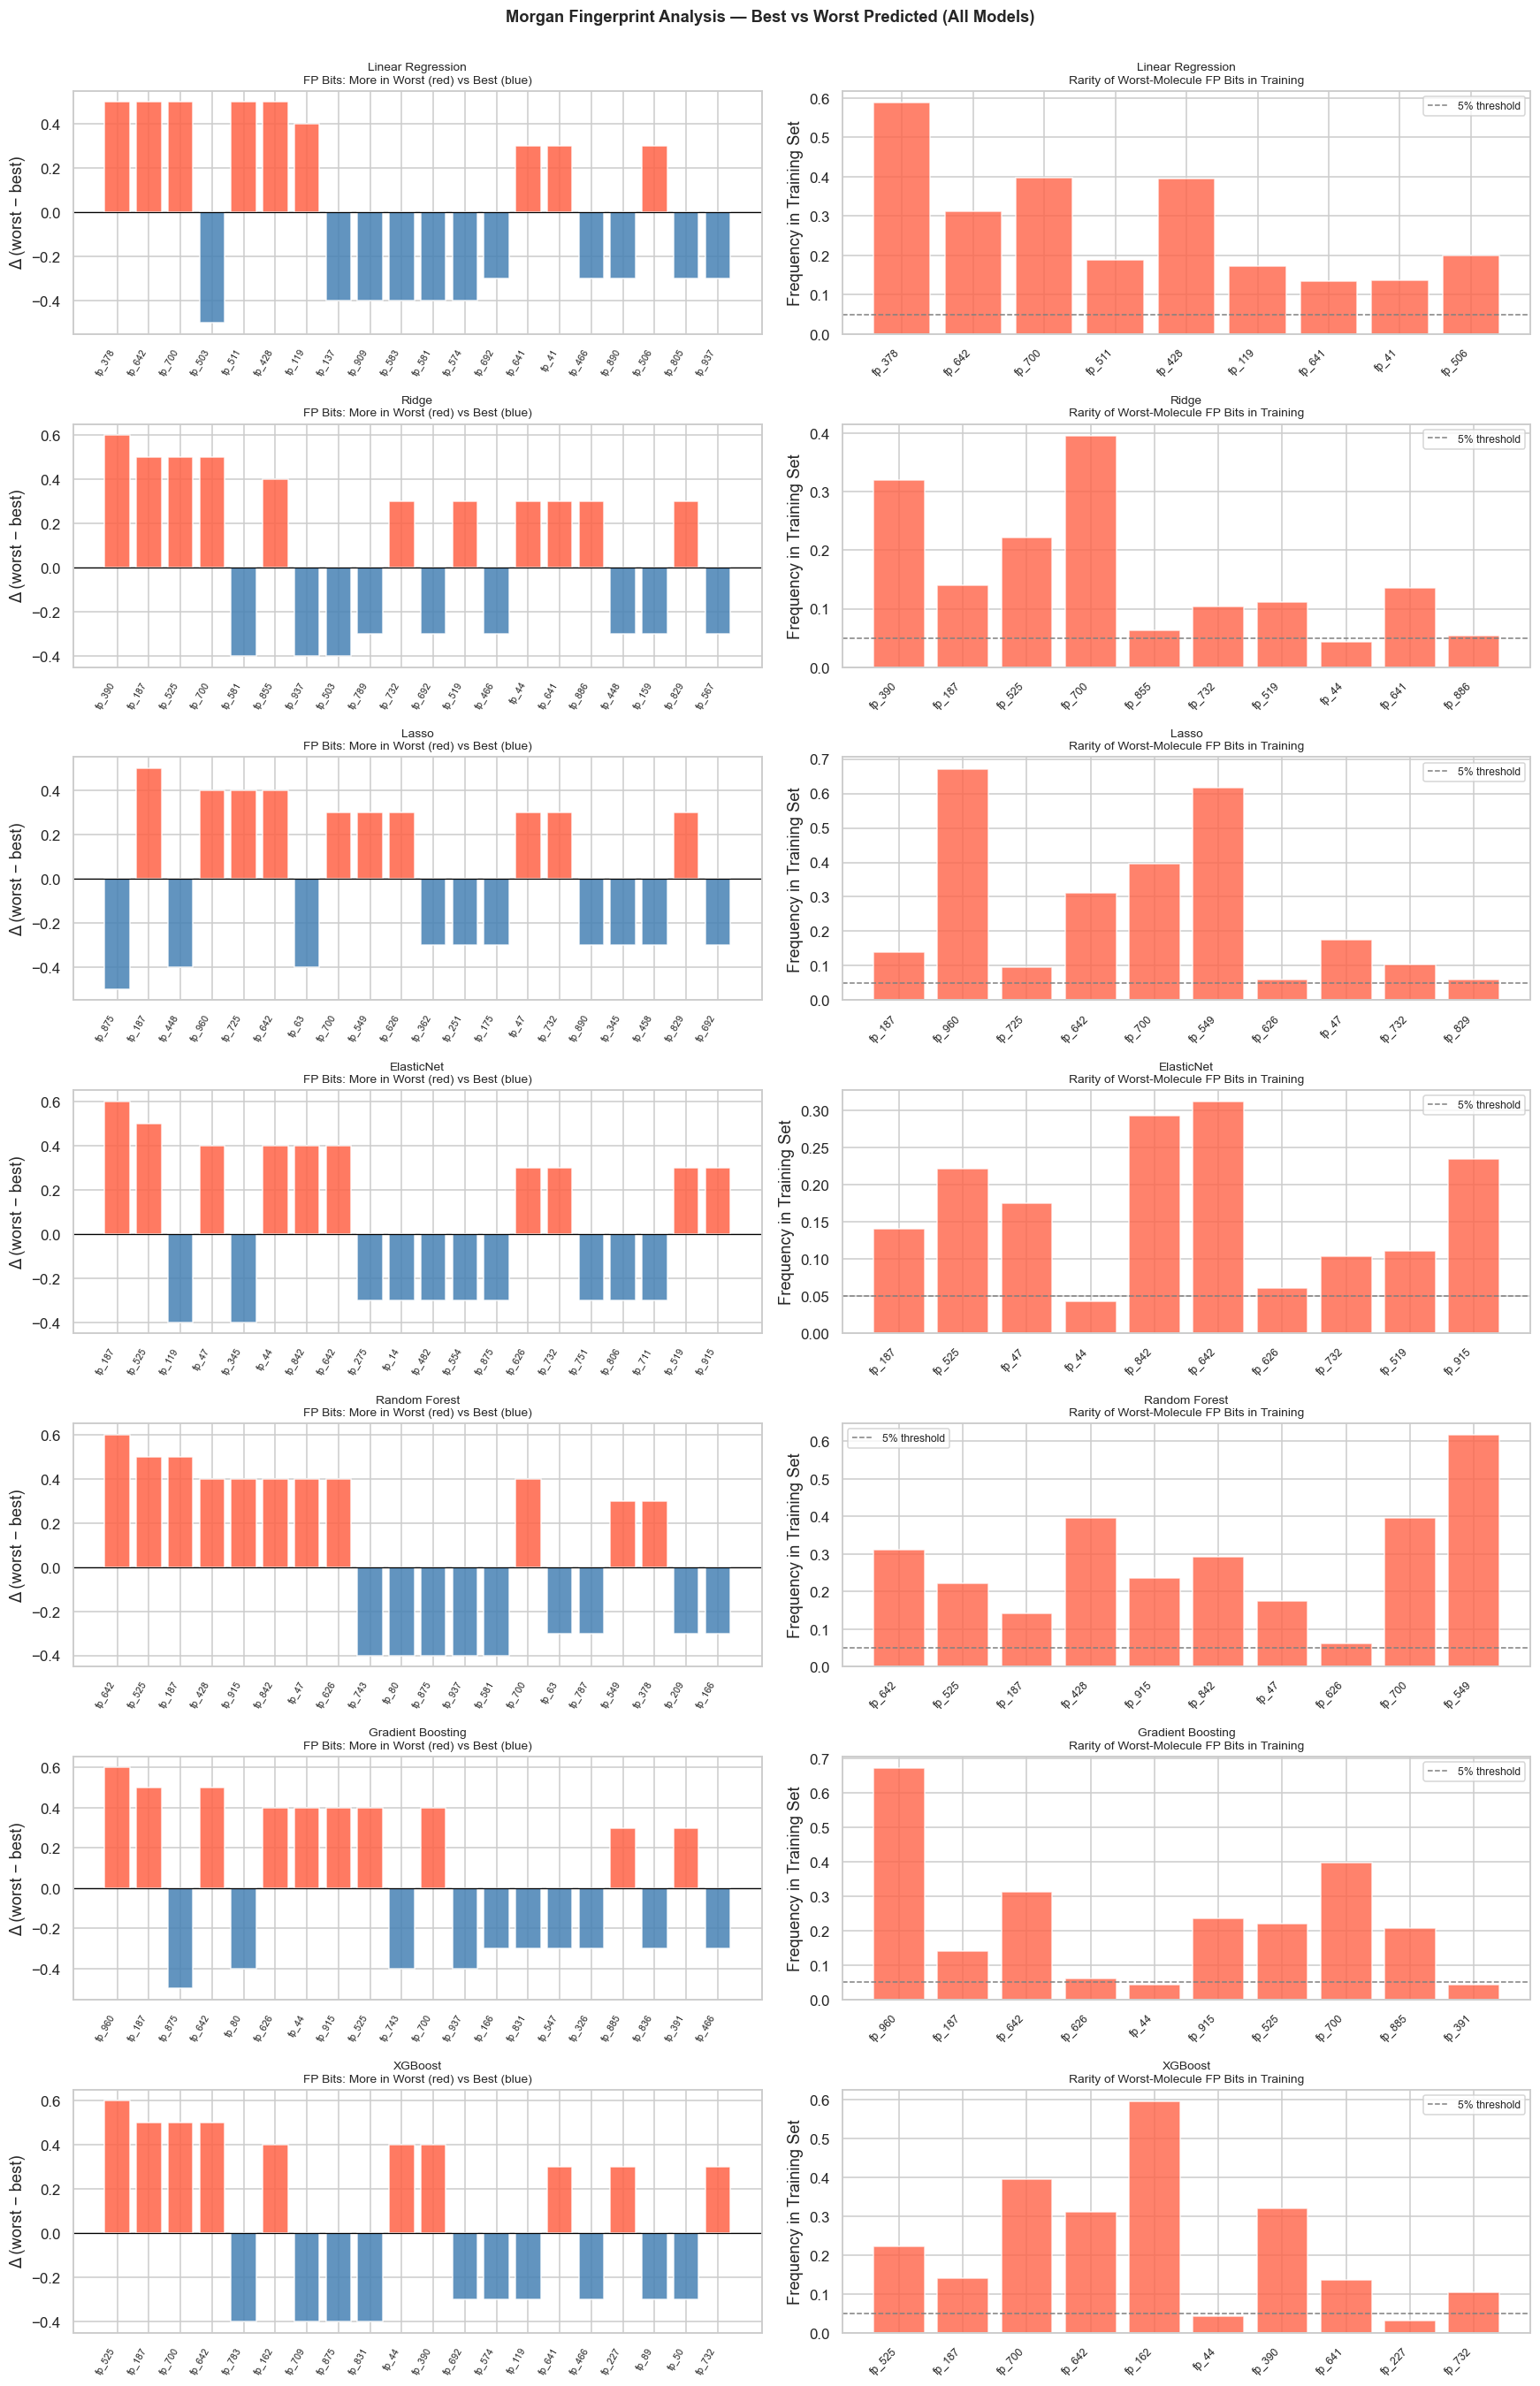


Interpretation:
  🔴 Red bars = fingerprint bits MORE common in WORST predicted molecules
     If these bits are RARE in training (right plot), the model never learned them
  🔵 Blue bars = bits more common in BEST predicted molecules (model knows these)


In [25]:
# ── Morgan fingerprint bit analysis for each model ────────────────────────────
def fp_array(smiles_list, n_bits=1024, radius=2):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi) if isinstance(smi, str) else None
        fp  = AllChem.GetMorganFingerprintAsBitVect(mol, radius, n_bits) if mol else np.zeros(n_bits)
        fps.append(np.array(fp))
    return np.array(fps) if fps else np.zeros((1, n_bits))

# Also get training set fingerprints for rarity check
train_fps = fp_array(df_tr_B[SMILES_COL].tolist())
train_bit_freq = train_fps.mean(axis=0)  # frequency of each bit in training set

fig_cols = 2
fig_rows = len(tuned_models)
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(16, 3.5*fig_rows))
if fig_rows == 1: axes = axes.reshape(1, -1)

for idx, (model_name, _) in enumerate(tuned_models):
    data = outlier_data[model_name]
    best_fps  = fp_array(data['best'][SMILES_COL].tolist())
    worst_fps = fp_array(data['worst'][SMILES_COL].tolist())
    
    mean_best  = best_fps.mean(axis=0)
    mean_worst = worst_fps.mean(axis=0)
    diff = mean_worst - mean_best
    
    top_diff_idx = np.argsort(np.abs(diff))[::-1][:20]
    colors_bar = ['tomato' if d > 0 else 'steelblue' for d in diff[top_diff_idx]]
    
    # FP difference plot
    ax = axes[idx, 0]
    ax.bar(range(20), diff[top_diff_idx], color=colors_bar, alpha=0.85)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(range(20))
    ax.set_xticklabels([f'fp_{i}' for i in top_diff_idx], rotation=60, ha='right', fontsize=7)
    ax.set_ylabel('Δ (worst − best)')
    ax.set_title(f'{model_name}\nFP Bits: More in Worst (red) vs Best (blue)', fontsize=9)
    
    # Rarity of worst-molecule fingerprint bits in training set
    ax2 = axes[idx, 1]
    worst_unique_bits = top_diff_idx[diff[top_diff_idx] > 0][:10]
    if len(worst_unique_bits) > 0:
        freq_in_train = train_bit_freq[worst_unique_bits]
        ax2.bar(range(len(worst_unique_bits)), freq_in_train, color='tomato', alpha=0.8)
        ax2.set_xticks(range(len(worst_unique_bits)))
        ax2.set_xticklabels([f'fp_{i}' for i in worst_unique_bits], rotation=45, ha='right', fontsize=8)
        ax2.set_ylabel('Frequency in Training Set')
        ax2.set_title(f'{model_name}\nRarity of Worst-Molecule FP Bits in Training', fontsize=9)
        ax2.axhline(0.05, color='gray', linestyle='--', linewidth=1, label='5% threshold')
        ax2.legend(fontsize=8)
    else:
        ax2.text(0.5, 0.5, 'No distinctive bits', ha='center', va='center', transform=ax2.transAxes)

plt.suptitle('Morgan Fingerprint Analysis — Best vs Worst Predicted (All Models)',
             fontsize=12, fontweight='bold', y=1.001)
plt.tight_layout(); plt.show()

print("\nInterpretation:")
print("  🔴 Red bars = fingerprint bits MORE common in WORST predicted molecules")
print("     If these bits are RARE in training (right plot), the model never learned them")
print("  🔵 Blue bars = bits more common in BEST predicted molecules (model knows these)")


---
## Stage 15 — Molecular Topology Analysis

Molecular topology — the arrangement and count of ring systems — is hypothesised to influence prediction quality in the COMPAS dataset. Linear acene-type systems (e.g., anthracene, tetracene) follow a well-understood Hückel gap-scaling law and may be more predictable than compact, branched, or irregular ring assemblies that create unusual electronic environments not well-represented in the training set.

Three topology descriptors are computed for the best-predicted and worst-predicted molecules of each model:
- **Total ring count** — distinguishes small from large polycyclic systems
- **Aromatic ring count** — quantifies the degree of aromaticity
- **Heavy atom count** — a proxy for molecular size independent of ring structure

Each model receives its own per-model histogram comparing the topology distribution of best vs. worst predicted molecules. A cross-model summary table and comparison chart then reveal whether the topology pattern is consistent across all seven models (a dataset-level structural signal) or specific to one or two model families (a model-level artefact).

Consistent topology differences across all models would support augmenting the training set with more diverse ring-size distributions to improve predictions on complex systems.

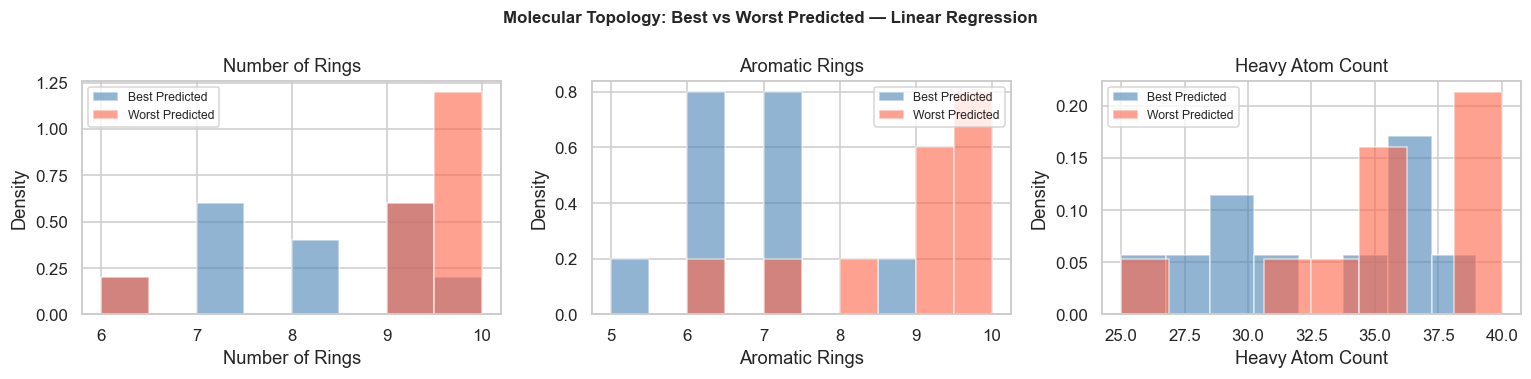

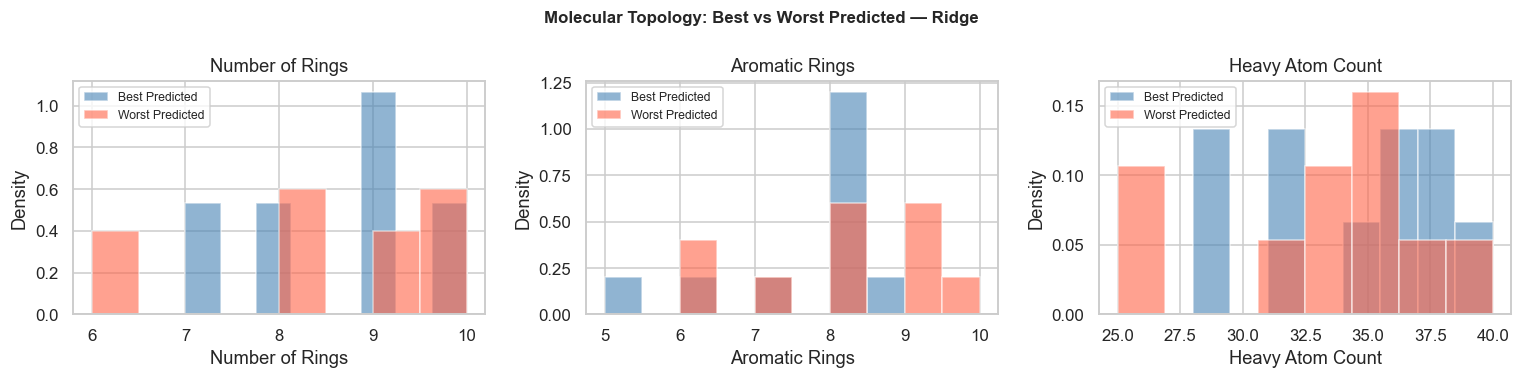

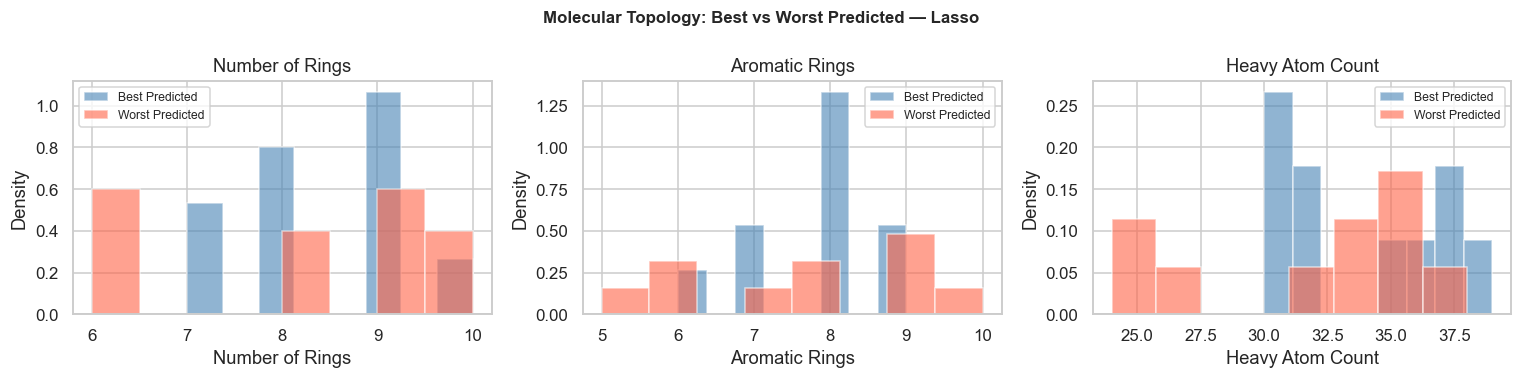

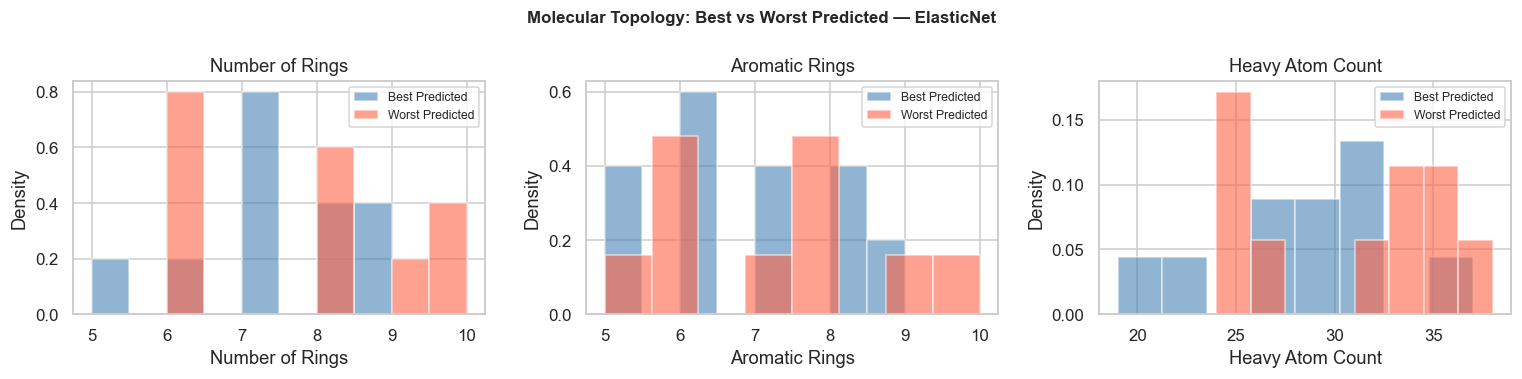

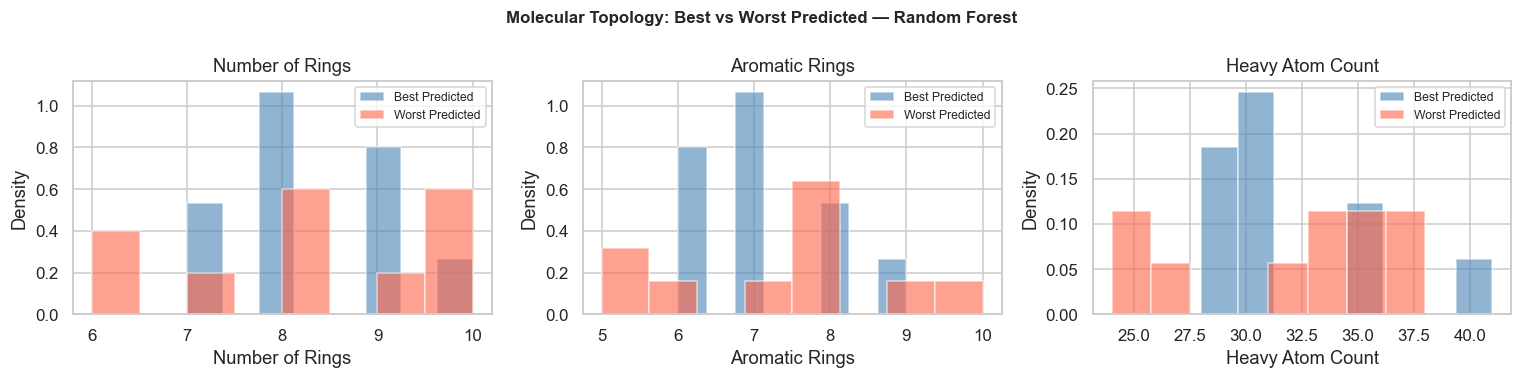

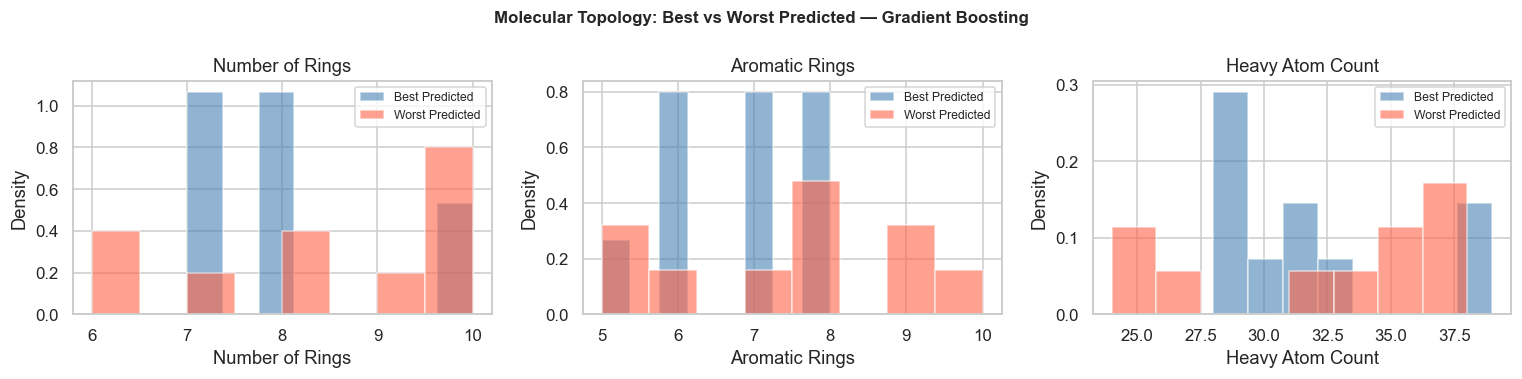

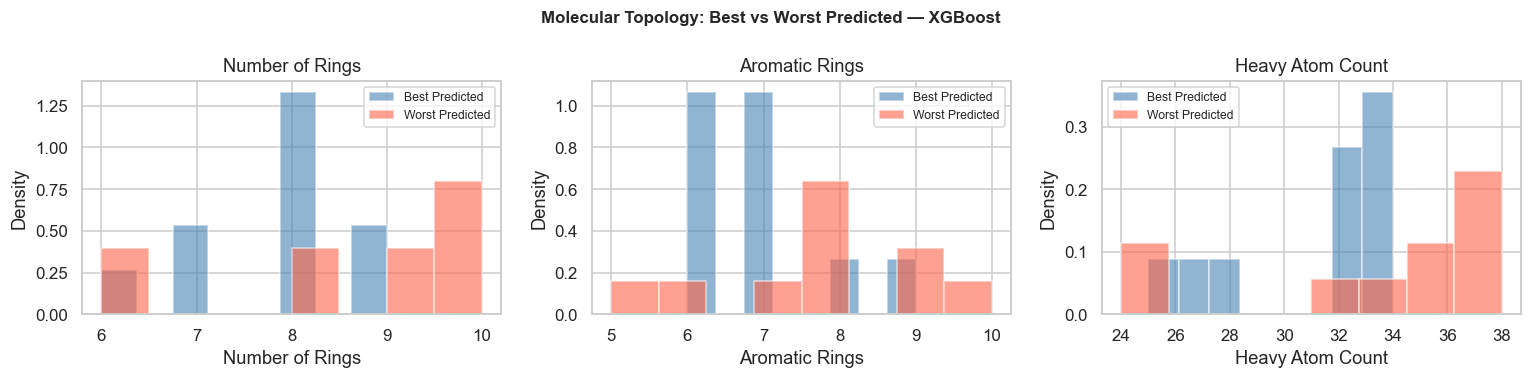

Topology Summary — Best vs Worst Predicted (all models):


Mean Arom Rings       Mean Heavy Atoms       Mean Rings  \
Group                        Best Worst             Best Worst       Best   
Model                                                                       
ElasticNet                    6.7   7.3             28.6  30.9        7.3   
Gradient Boosting             6.8   7.5             31.9  32.7        8.0   
Lasso                         7.8   7.7             33.9  31.9        8.4   
Linear Regression             6.6   8.8             32.3  35.7        8.0   
Random Forest                 7.1   7.4             31.9  32.2        8.3   
Ridge                         7.5   8.0             34.1  33.5        8.6   
XGBoost                       6.9   7.8             30.9  33.7        7.8   

                         
Group             Worst  
Model                    
ElasticNet          7.7  
Gradient Boosting   8.4  
Lasso               8.1  
Linear Regression   9.3  
Random Forest       8.2  
Ridge               8.4  
XGBoost             8.6

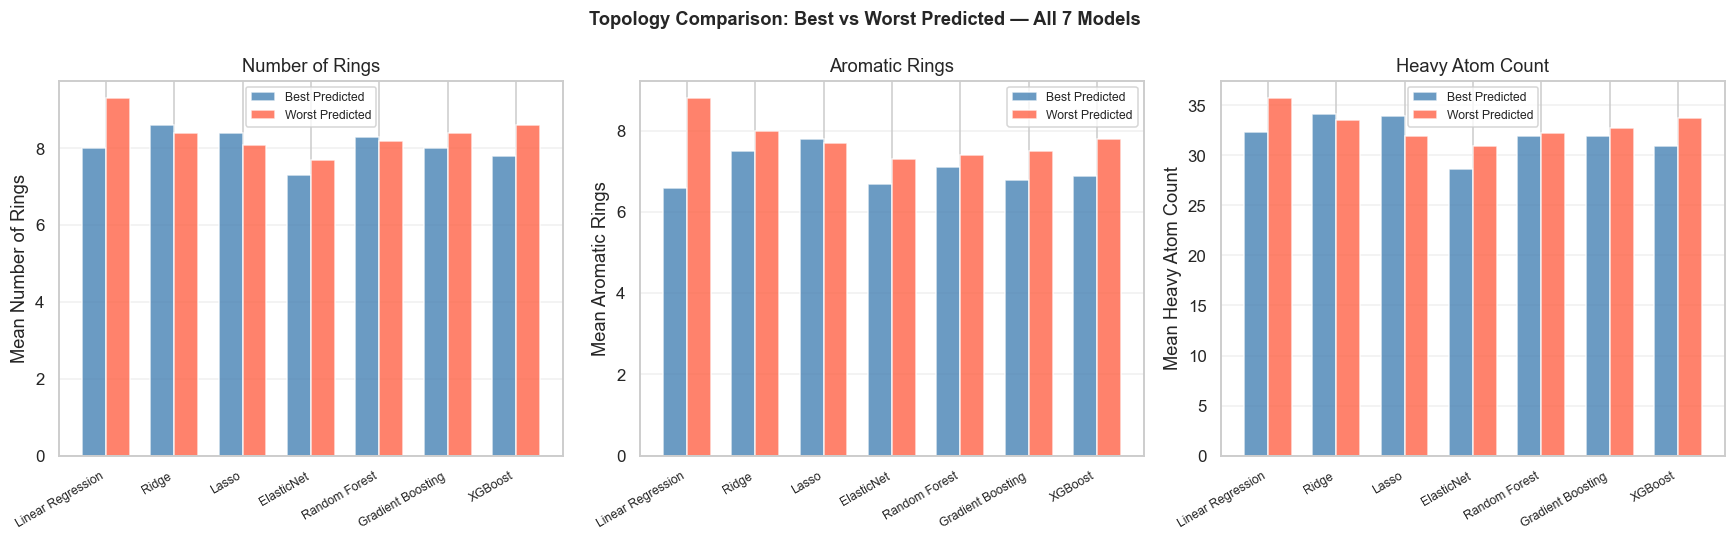

Interpretation:
  Worst have MORE rings  -> large/complex structures harder to predict
  Worst have FEWER rings -> small/unusual structures harder to predict
  Similar ring counts   -> topology NOT the key factor; check FP bits


In [26]:
# ── Topology descriptors — ALL models ────────────────────────────────────────
def get_topology(smiles):
    """Compute topology features for a SMILES string."""
    mol = Chem.MolFromSmiles(smiles) if isinstance(smiles, str) else None
    if mol is None:
        return {"n_rings": np.nan, "n_arom_rings": np.nan, "n_heavy": np.nan}
    ring_info = mol.GetRingInfo()
    n_rings = ring_info.NumRings()
    n_arom  = sum(1 for ring in ring_info.AtomRings()
                  if all(mol.GetAtomWithIdx(a).GetIsAromatic() for a in ring))
    return {"n_rings": n_rings, "n_arom_rings": n_arom, "n_heavy": mol.GetNumHeavyAtoms()}

# ── Run topology comparison for EVERY model ───────────────────────────────────
topo_summary = []

for model_name, _ in tuned_models:
    data     = outlier_data[model_name]
    best_sm  = data["best"][SMILES_COL].tolist()
    worst_sm = data["worst"][SMILES_COL].tolist()

    topo_best  = pd.DataFrame([get_topology(s) for s in best_sm]).assign(group="Best",  Model=model_name)
    topo_worst = pd.DataFrame([get_topology(s) for s in worst_sm]).assign(group="Worst", Model=model_name)
    topo_all   = pd.concat([topo_best, topo_worst], ignore_index=True)

    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
    for ax, col, label in zip(axes,
        ["n_rings", "n_arom_rings", "n_heavy"],
        ["Number of Rings", "Aromatic Rings", "Heavy Atom Count"]):
        for grp, color in [("Best", "steelblue"), ("Worst", "tomato")]:
            vals = topo_all[topo_all["group"]==grp][col].dropna()
            if len(vals) > 0:
                ax.hist(vals, bins=8, alpha=0.6, label=grp + " Predicted",
                        color=color, density=True)
        ax.set_xlabel(label); ax.set_ylabel("Density")
        ax.set_title(label); ax.legend(fontsize=8)

    plt.suptitle("Molecular Topology: Best vs Worst Predicted — " + model_name,
                 fontsize=11, fontweight="bold")
    plt.tight_layout(); plt.show()

    for grp in ["Best", "Worst"]:
        sub = topo_all[topo_all["group"]==grp]
        topo_summary.append({
            "Model": model_name, "Group": grp,
            "Mean Rings": sub["n_rings"].mean(),
            "Mean Arom Rings": sub["n_arom_rings"].mean(),
            "Mean Heavy Atoms": sub["n_heavy"].mean()
        })

# ── Cross-model topology summary table ───────────────────────────────────────
topo_summary_df = pd.DataFrame(topo_summary)
print("Topology Summary — Best vs Worst Predicted (all models):")
print("="*75)
pivot_topo = topo_summary_df.pivot_table(
    index="Model", columns="Group",
    values=["Mean Rings", "Mean Arom Rings", "Mean Heavy Atoms"]
).round(2)
display(pivot_topo)

# ── Cross-model comparison bar chart ─────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = [("Mean Rings", "Number of Rings"),
           ("Mean Arom Rings", "Aromatic Rings"),
           ("Mean Heavy Atoms", "Heavy Atom Count")]

model_list = topo_summary_df["Model"].unique()
x = np.arange(len(model_list))
w = 0.35

for ax, (metric, label) in zip(axes, metrics):
    for j, (grp, color) in enumerate([("Best", "steelblue"), ("Worst", "tomato")]):
        vals = [
            topo_summary_df[
                (topo_summary_df["Model"]==m) & (topo_summary_df["Group"]==grp)
            ][metric].values[0]
            for m in model_list
        ]
        ax.bar(x + (j - 0.5)*w, vals, w, label=grp + " Predicted",
               color=color, alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(model_list, rotation=30, ha="right", fontsize=8)
    ax.set_ylabel("Mean " + label); ax.set_title(label)
    ax.legend(fontsize=8); ax.grid(axis="y", alpha=0.3)

plt.suptitle("Topology Comparison: Best vs Worst Predicted — All 7 Models",
             fontsize=12, fontweight="bold")
plt.tight_layout(); plt.show()

print("Interpretation:")
print("  Worst have MORE rings  -> large/complex structures harder to predict")
print("  Worst have FEWER rings -> small/unusual structures harder to predict")
print("  Similar ring counts   -> topology NOT the key factor; check FP bits")


---
## Stage 16 — Multi-Seed Robustness Validation

All results reported so far are based on a single random state (seed 42). A single scaffold split may be favourable or unfavourable for particular model families depending on which specific scaffolds end up in the test set. To assess the stability of model rankings and quantify result uncertainty, the complete experiment — sampling, feature engineering, scaffold splitting, and training — is repeated under three independent random seeds (42, 123, 777).

Mean R² and MAE are reported with standard deviations across the three runs. Models with small standard deviations produce stable, reproducible results regardless of which molecules are held out for testing. Models with large standard deviations are sensitive to the specific train/test split, which may indicate overfitting or high sensitivity to scaffold composition.

For computational efficiency, this robustness check uses default model parameters rather than re-running the full hyperparameter search for each seed. The primary goal is to confirm that model *rankings* are stable — not to find the best absolute performance.

In [27]:
# ── Multi-seed robustness (Strategy B, default params for speed) ───────────────
SEEDS = [42, 123, 777]
robustness_results = []

print("Multi-seed robustness check (Strategy B, default parameters):")
print("="*65)

for seed in SEEDS:
    print(f"\n  Seed {seed}:")
    df_B_seed = stratified_gap_sample(df, SAMPLE_N, seed=seed)
    X_s, y_s  = build_features(df_B_seed)
    X_tr_s, X_te_s, y_tr_s, y_te_s, _, _ = scaffold_split(df_B_seed, X_s, y_s, seed=seed)
    
    for model_name, model_factory in get_default_models():
        pipe = make_pipeline(model_factory)
        pipe.fit(X_tr_s, y_tr_s)
        pred = pipe.predict(X_te_s)
        r2   = r2_score(y_te_s, pred)
        mae  = mean_absolute_error(y_te_s, pred)
        robustness_results.append({'Model': model_name, 'Seed': seed, 'Test R²': r2, 'MAE': mae})
        print(f"    {model_name:<25s}  R²={r2:.4f}  MAE={mae:.4f}")

rob_df = pd.DataFrame(robustness_results)

# Summary: mean ± std
rob_summary = rob_df.groupby('Model').agg(
    R2_mean=('Test R²','mean'), R2_std=('Test R²','std'),
    MAE_mean=('MAE','mean'),    MAE_std=('MAE','std')
).round(4).sort_values('R2_mean', ascending=False)

print("\n\nROBUSTNESS SUMMARY (mean ± std across 3 seeds):")
print("="*65)
for model, row in rob_summary.iterrows():
    print(f"  {model:<25s}  R²={row.R2_mean:.4f}±{row.R2_std:.4f}  MAE={row.MAE_mean:.4f}±{row.MAE_std:.4f}")

display(rob_summary)


Multi-seed robustness check (Strategy B, default parameters):

  Seed 42:
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.4% (handled by median imputation in pipeline)
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓
    Linear Regression          R²=0.6673  MAE=0.3121
    Ridge                      R²=0.6844  MAE=0.3060
    Lasso                      R²=0.3161  MAE=0.4621
    ElasticNet                 R²=0.3888  MAE=0.4371
    Random Forest              R²=0.6549  MAE=0.3218
    Gradient Boosting          R²=0.7189  MAE=0.2875
    XGBoost                    R²=0.7395  MAE=0.2765

  Seed 123:
  Building features for 5,000 molecules...
  ✓ Feature matrix: (5000, 1264)  |  target: (5000,)
  NaN proportion: 0.4% (handled by median imputation in pipeline)
  Unique scaffolds: 5,000
  Train: 4,000  Test: 1,000  Scaffold overlap: 0 ✓
    Linear Regression          R²=0.6070  MAE=0.3132
    Ridge  

R2_mean  R2_std  MAE_mean  MAE_std
Model                                                
XGBoost             0.7245  0.0133    0.2718   0.0058
Gradient Boosting   0.7017  0.0152    0.2836   0.0054
Ridge               0.6535  0.0271    0.3063   0.0025
Random Forest       0.6473  0.0075    0.3099   0.0108
Linear Regression   0.6286  0.0337    0.3159   0.0056
ElasticNet          0.3726  0.0143    0.4278   0.0081
Lasso               0.3019  0.0143    0.4517   0.0090

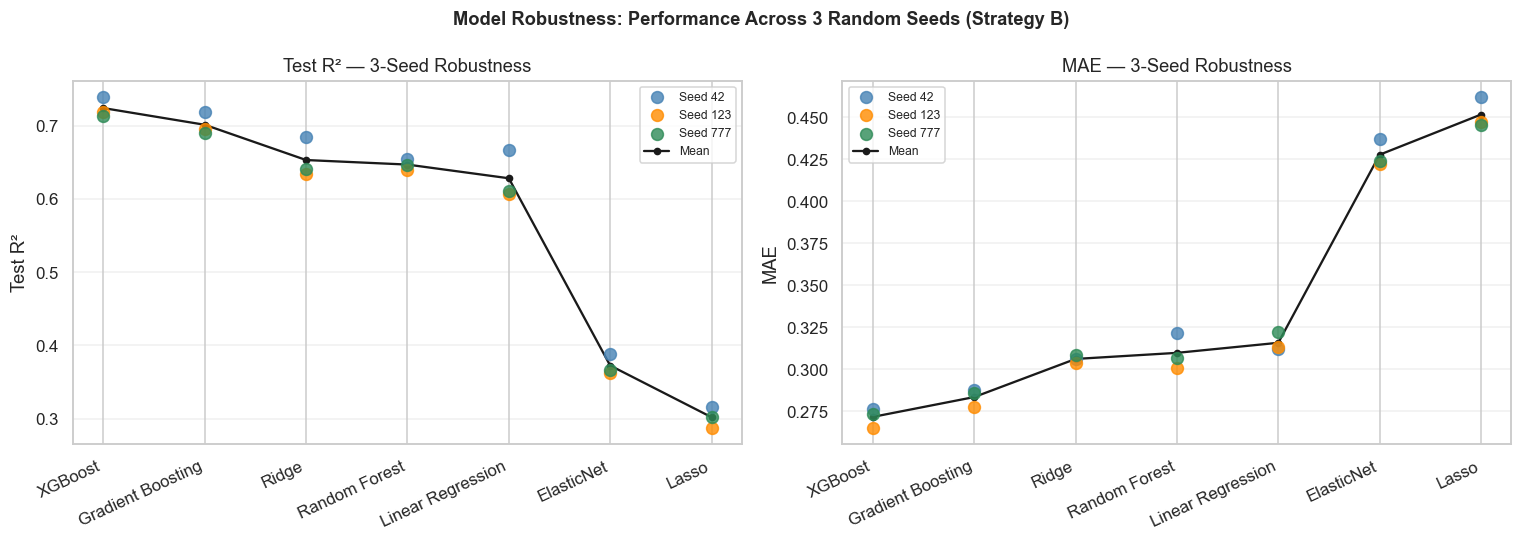

In [28]:
# ── Visualise robustness ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric, label in [(axes[0],'Test R²','Test R²'), (axes[1],'MAE','MAE')]:
    models_sorted = rob_df.groupby('Model')[metric].mean().sort_values(ascending=(metric=='MAE')).index
    positions = {m:i for i,m in enumerate(models_sorted)}
    
    seed_colors = {42:'steelblue', 123:'darkorange', 777:'seagreen'}
    for seed in SEEDS:
        sub = rob_df[rob_df['Seed']==seed]
        xs  = [positions[m] for m in sub['Model']]
        ax.scatter(xs, sub[metric], color=seed_colors[seed], label=f'Seed {seed}',
                   s=60, zorder=3, alpha=0.8)
    
    # Mean line
    means = [rob_df[rob_df['Model']==m][metric].mean() for m in models_sorted]
    ax.plot(range(len(models_sorted)), means, 'k-o', linewidth=1.5, markersize=4, label='Mean')
    
    ax.set_xticks(range(len(models_sorted)))
    ax.set_xticklabels(models_sorted, rotation=25, ha='right')
    ax.set_ylabel(label); ax.set_title(f'{label} — 3-Seed Robustness')
    ax.legend(fontsize=8); ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Robustness: Performance Across 3 Random Seeds (Strategy B)',
             fontsize=12, fontweight='bold')
plt.tight_layout(); plt.show()


---
## Stage 17 — Sampling Strategy Comparison

The final comparative analysis compiles performance across all sampling strategies (A, B, C), both before and after hyperparameter tuning, into a single comprehensive table. The tuning gain column (Tuned B − Default B) quantifies how much each model benefits from hyperparameter optimisation relative to its default configuration.

This comparison answers three practical questions:
1. Does distribution-aware sampling (Strategy B) produce meaningfully better models than random selection (Strategy A) — and is this advantage consistent across all model families?
2. Does enforcing boron balance (Strategy C) change model performance or just feature rankings?
3. Which models show the largest tuning gains — and what does this reveal about their sensitivity to hyperparameter choice?

The best-performing strategy per model is identified, and consistent winners across models are interpreted as genuine properties of the sampling approach rather than model-specific artefacts.

In [29]:
# ── Strategy comparison table ─────────────────────────────────────────────────
# Default performance pivot
default_pivot = default_df.pivot_table(index='Model', columns='Strategy', values='Test R²').round(4)
default_pivot.columns = [f'Default {c}' for c in default_pivot.columns]

# Tuned performance pivot
tuned_pivot = tuned_all_df.pivot_table(index='Model', columns='Strategy', values='Test R²').round(4)
tuned_pivot.columns = [f'Tuned {c}' for c in tuned_pivot.columns]

comparison_full = pd.concat([default_pivot, tuned_pivot], axis=1)
comparison_full['Tuning Gain (B)'] = (comparison_full['Tuned B — Stratified'] - 
                                       comparison_full['Default B — Stratified']).round(4)

print("COMPREHENSIVE STRATEGY COMPARISON (Test R²):")
display(comparison_full.sort_values('Tuned B — Stratified', ascending=False))

# Best strategy per model
print("\nBest sampling strategy per model (tuned):")
for model in tuned_pivot.index:
    best_strat = tuned_pivot.loc[model].idxmax()
    best_r2    = tuned_pivot.loc[model].max()
    print(f"  {model:<25s}: {best_strat}  (R²={best_r2:.4f})")


COMPREHENSIVE STRATEGY COMPARISON (Test R²):


Default A — Random  Default B — Stratified  \
Model                                                           
Gradient Boosting              0.6857                  0.7189   
XGBoost                        0.7091                  0.7395   
Ridge                          0.6245                  0.6844   
ElasticNet                     0.3823                  0.3888   
Lasso                          0.3253                  0.3161   
Linear Regression              0.5954                  0.6673   
Random Forest                  0.6500                  0.6549   

                   Default C — Boron-aware  Tuned A — Random  \
Model                                                          
Gradient Boosting                   0.6958            0.7350   
XGBoost                             0.7144            0.7432   
Ridge                               0.6767            0.6875   
ElasticNet                          0.4188            0.6791   
Lasso                               0.3200            0.6743   
Linear Regression                   0.6420            0.6350   
Random Forest                       0.6409            0.6702   

                   Tuned B — Stratified  Tuned C — Boron-aware  \
Model                                                            
Gradient Boosting                0.7523                 0.7458   
XGBoost                          0.7487                 0.7405   
Ridge                            0.7118                 0.7033   
ElasticNet                       0.7068                 0.6983   
Lasso                            0.7050                 0.6960   
Linear Regression                0.6673                 0.6624   
Random Forest                    0.6662                 0.6768   

                   Tuning Gain (B)  
Model                               
Gradient Boosting           0.0334  
XGBoost                     0.0092  
Ridge                       0.0274  
ElasticNet                  0.3180  
Lasso                       0.3889  
Linear Regression           0.0000  
Random Forest               0.0113


Best sampling strategy per model (tuned):
  ElasticNet               : Tuned B — Stratified  (R²=0.7068)
  Gradient Boosting        : Tuned B — Stratified  (R²=0.7523)
  Lasso                    : Tuned B — Stratified  (R²=0.7050)
  Linear Regression        : Tuned B — Stratified  (R²=0.6673)
  Random Forest            : Tuned C — Boron-aware  (R²=0.6768)
  Ridge                    : Tuned B — Stratified  (R²=0.7118)
  XGBoost                  : Tuned B — Stratified  (R²=0.7487)


---
## Stage 18 — Chemical Reasoning and Mechanistic Discussion

### Why Tree-Based Models Outperform Linear Models

The consistent performance gap between gradient-boosted models (Gradient Boosting R² = 0.752, XGBoost R² = 0.749) and linear models (Ridge R² = 0.712, Lasso/ElasticNet R² ≈ 0.705, Linear Regression R² = 0.667) reflects two fundamental chemical realities of the HOMO-LUMO prediction problem.

**Multicollinearity in molecular descriptor space.** Molecular descriptors are not independent: molecular weight grows with ring count; ring count correlates with conjugation length; conjugation length determines π-orbital delocalisation, which governs the gap. When the design matrix contains hundreds of mutually correlated features, ordinary least squares produces coefficients that are individually large and unstable — each coefficient compensates for the others, rather than estimating genuine marginal effects. This manifests as the extreme feature importance concentration observed in Stage 9 for Linear Regression, where Chi1n dominates with a permutation importance value of ~19,038 — orders of magnitude larger than any other feature — while regularised models (Ridge, Lasso, ElasticNet) distribute importance across many descriptors, confirming that regularisation recovers more stable and chemically interpretable feature rankings. Tree-based models are structurally immune to multicollinearity: at each split node, the algorithm selects the single most informative feature; correlated features simply take turns being selected across the ensemble without creating numerical instability.

**Nonlinear structure-property relationships.** The HOMO-LUMO gap is fundamentally nonlinear in any single structural descriptor. Hückel molecular orbital theory predicts that the gap of a linear acene scales approximately as 1/n with the number of fused rings — a strong nonlinearity that a linear model cannot represent. Nitrogen substitution effects depend on whether the nitrogen occupies an α or β position in a heteroaromatic ring, creating position-specific discontinuities invisible to linear combinations of counts. Gradient Boosting and XGBoost capture these relationships through hierarchical decision boundaries that are unrestricted in their functional form.

### The Electronic Role of Boron

Boron (Group 13) has three valence electrons and adopts sp² hybridisation in aromatic rings, leaving an empty p-orbital perpendicular to the molecular plane. When incorporated into a conjugated π-system, this empty p-orbital participates directly in π-conjugation as an electron acceptor. The consequences for the HOMO-LUMO gap are substantial:

- The LUMO energy is significantly lowered relative to an all-carbon analogue, because the empty boron p-orbital provides a low-energy orbital for accepting electron density
- The HOMO energy is relatively unaffected by boron substitution, since the occupied π-electrons prefer to reside on the more electronegative carbon and nitrogen atoms
- The net effect is a compressed HOMO-LUMO gap: in this dataset, boron-containing molecules have a mean gap of 4.51 eV versus 5.07 eV for non-boron systems — a shift of ~0.56 eV that is statistically significant and chemically meaningful, though the distributions overlap substantially given the wide gap range of 1.76–7.88 eV

This creates a distributional shift between boron and non-boron molecules. Any model that can detect boron presence achieves moderate predictive accuracy on the mixed dataset. However, the three-way boron comparison in Stage 12 reveals that boron-free models actually outperform mixed-dataset models — indicating that boron introduces distributional complexity rather than clean additional signal. The boron-only chemical space is harder to predict (lower R² across all models) because within that space, the remaining structural variation produces subtler gap differences that require finer-grained structural features to resolve.

### Morgan Fingerprint Bits and Prediction Failure

When a Morgan fingerprint bit appears consistently in poorly predicted molecules but rarely in training molecules, it encodes a **structural fragment the model has not encountered during training**. Common patterns in the COMPAS dataset include unusual ring fusion geometries (five-membered rings inserted into large PAH frameworks), B-N heterocyclic co-doping patterns, and extended linear acenes beyond the size range well-represented in the training set. The rarity analysis in Stage 14 quantifies this: bits appearing in fewer than 5% of training molecules are strong candidates for structural novelty driving prediction failure.

The implication is practical: improving performance on outlier molecules requires targeted augmentation of the training set with examples containing those rare fragments, rather than general model improvements.

### Scaffold Splitting and the Generalisation Penalty

The reduction in R² when moving from random to scaffold splitting — typically 5–15 percentage points in this domain — is sometimes misinterpreted as poor model performance. It is more accurately understood as the **honest cost of structural novelty**: the model is being evaluated on molecules with core scaffolds it has never seen, which is the realistic deployment scenario for any materials or drug discovery screening application. Random splitting produces inflated metrics by allowing the model to partially interpolate between near-duplicate molecules in train and test. Scaffold splitting removes this shortcut and reveals genuine generalisation capacity.

In this experiment, every scaffold in the dataset is unique (5,000 unique scaffolds across 5,000 molecules), meaning the scaffold split is maximally stringent — every test molecule has a completely novel scaffold. The reported R² values therefore represent a lower bound on performance that would be expected in a real screening campaign where some test scaffolds overlap with known chemistry.

---
## Stage 19 — Final Summary & Conclusions


In [30]:
# ── Comprehensive final results table ────────────────────────────────────────
final_rows = []
for model_name, _ in tuned_models:
    r2_stB  = r2_score(y_te_tune, preds_B[model_name])
    mae_stB = mean_absolute_error(y_te_tune, preds_B[model_name])
    r2_bo   = next(r['Test R²'] for r in boron_only_results if r['Model']==model_name)
    r2_bf   = next(r['Test R²'] for r in boron_free_results if r['Model']==model_name)
    r2_rob  = rob_summary.loc[model_name, 'R2_mean'] if model_name in rob_summary.index else np.nan
    r2_rob_std = rob_summary.loc[model_name, 'R2_std'] if model_name in rob_summary.index else np.nan
    final_rows.append({
        'Model': model_name,
        'R² (Strategy B)': r2_stB,
        'MAE (Strategy B)': mae_stB,
        'R² Boron-only': r2_bo,
        'R² Boron-free': r2_bf,
        'R² Mean±Std (3 seeds)': f"{r2_rob:.4f}±{r2_rob_std:.4f}" if not np.isnan(r2_rob) else 'N/A'
    })

final_df = pd.DataFrame(final_rows).sort_values('R² (Strategy B)', ascending=False)
print("FINAL COMPREHENSIVE RESULTS")
print("="*70)
display(final_df.round(4))

best = final_df.iloc[0]
print(f"\n✓ BEST MODEL: {best['Model']}")
print(f"  Test R² (Strategy B) = {best['R² (Strategy B)']:.4f}")
print(f"  MAE                  = {best['MAE (Strategy B)']:.4f} eV")


FINAL COMPREHENSIVE RESULTS


Model  R² (Strategy B)  MAE (Strategy B)  R² Boron-only  \
5  Gradient Boosting           0.7523            0.2662         0.6350   
6            XGBoost           0.7487            0.2704         0.6319   
1              Ridge           0.7118            0.2927         0.6135   
3         ElasticNet           0.7068            0.2940         0.6093   
2              Lasso           0.7050            0.2951         0.6065   
0  Linear Regression           0.6673            0.3121         0.4818   
4      Random Forest           0.6662            0.3154         0.5579   

   R² Boron-free R² Mean±Std (3 seeds)  
5         0.7982         0.7017±0.0152  
6         0.7917         0.7245±0.0133  
1         0.7479         0.6535±0.0271  
3         0.7402         0.3726±0.0143  
2         0.7416         0.3019±0.0143  
0         0.7349         0.6286±0.0337  
4         0.7310         0.6473±0.0075


✓ BEST MODEL: Gradient Boosting
  Test R² (Strategy B) = 0.7523
  MAE                  = 0.2662 eV


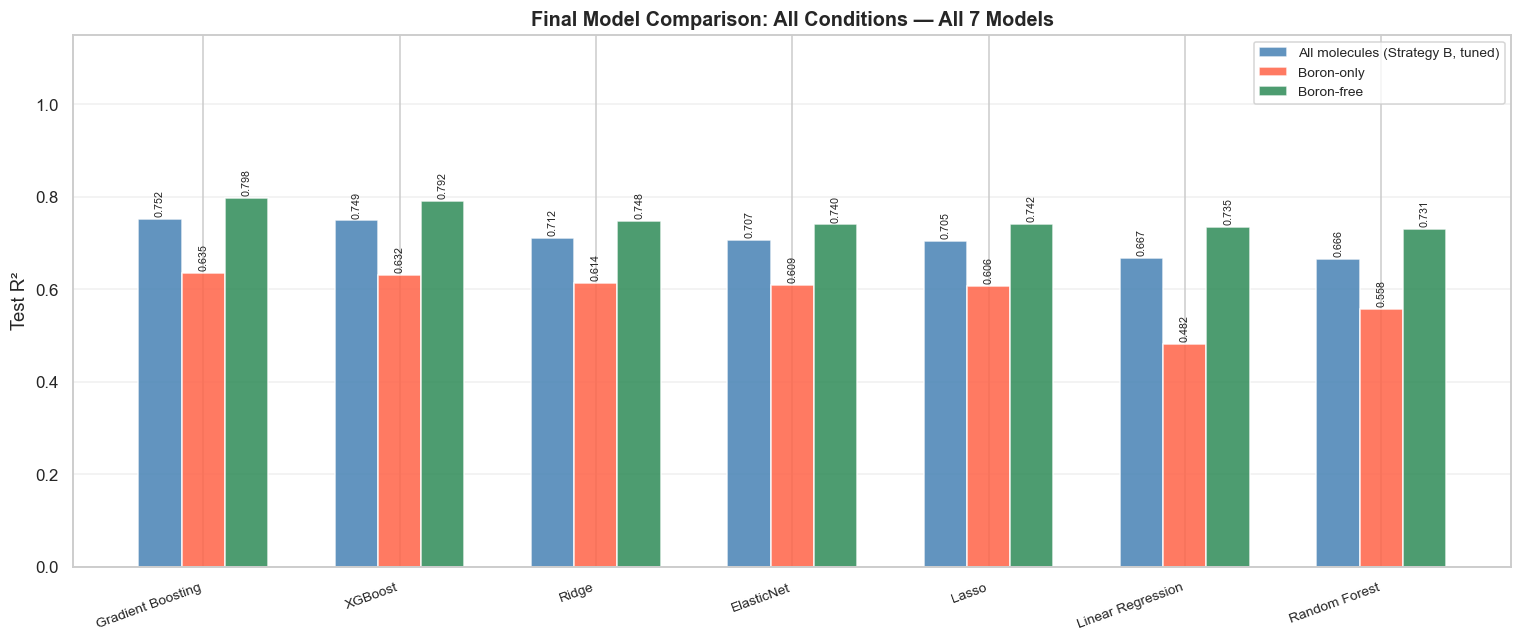

In [31]:
# ── Final comprehensive bar chart ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))

models_order = final_df['Model'].tolist()
x = np.arange(len(models_order))
w = 0.22

datasets = [
    ('R² (Strategy B)',  'steelblue',  'All molecules (Strategy B, tuned)'),
    ('R² Boron-only',    'tomato',      'Boron-only'),
    ('R² Boron-free',    'seagreen',    'Boron-free'),
]

for i, (col, color, label) in enumerate(datasets):
    vals = final_df[col].values
    bars = ax.bar(x + (i-1)*w, vals, w, label=label, color=color, alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=7, rotation=90)

ax.set_xticks(x); ax.set_xticklabels(models_order, rotation=20, ha='right', fontsize=9)
ax.set_ylabel('Test R²'); ax.set_ylim(0, 1.15)
ax.set_title('Final Model Comparison: All Conditions — All 7 Models', fontsize=13, fontweight='bold')
ax.legend(fontsize=9); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()


---
## Summary and Conclusions

### Experimental Configuration

| Parameter | Value |
|:---|:---|
| Dataset | COMPAS-2D, 156,000 rows; 52,000 neutral (charge=0) molecules used |
| Working subset | 5,000 molecules per strategy (3 sampling strategies) |
| Features | 1,264 total: 23 structural + ~217 RDKit descriptors + 1,024 Morgan fingerprint bits |
| Train/test split | Murcko scaffold split, 80/20, zero scaffold overlap (5,000 unique scaffolds) |
| Preprocessing | Median imputation + RobustScaler, uniform across all models |
| Hyperparameter search | RandomizedSearchCV, n_iter=30, cv=3, uniform across all models |
| Evaluation metrics | R², MAE, RMSE (test set) + Train R² (overfit gap) |

---

### Key Results

| Model | Train R² | Test R² (Strat. B) | MAE (eV) | Overfit Gap |
|:---|:---:|:---:|:---:|:---:|
| Gradient Boosting | 0.940 | **0.752** | 0.266 | 0.188 |
| XGBoost | 0.935 | **0.749** | 0.270 | 0.186 |
| Ridge | 0.774 | 0.712 | 0.293 | 0.062 |
| ElasticNet | 0.753 | 0.707 | 0.294 | 0.046 |
| Lasso | 0.755 | 0.705 | 0.295 | 0.050 |
| Linear Regression | 0.819 | 0.667 | 0.312 | 0.152 |
| Random Forest | 0.936 | 0.666 | 0.315 | 0.270 |

---

### Key Findings

**1. Model performance hierarchy is consistent and chemically explainable.**  
Gradient Boosting (R² = 0.752) and XGBoost (R² = 0.749) lead consistently, followed by regularised linear models (Ridge 0.712, ElasticNet 0.707, Lasso 0.705), with Linear Regression and Random Forest ranking lowest among tuned models. The tree model advantage reflects immunity to multicollinearity and capacity to capture nonlinear structure-property relationships. Random Forest achieves the highest training R² (0.936) but the lowest test R² among ensemble models (0.666), a train-test gap of 0.270 — the largest overfit gap observed — reflecting aggressive memorisation of training scaffolds without generalisation.

**2. Stratified sampling (Strategy B) consistently outperforms random sampling (Strategy A).**  
Across all seven models and both default and tuned conditions, Strategy B produces higher test R² than Strategy A. Strategy B is the best strategy for six of seven models when tuned. The advantage is most pronounced for linear models (Linear Regression gains ~7 R² points from A to B) and modest for tree models (~1–2 points), consistent with linear models being more sensitive to distributional coverage of the target variable.

**3. Boron-free models outperform mixed-dataset models — the unexpected central finding.**  
Boron-free models achieve the highest R² across all model families (Gradient Boosting: 0.798, XGBoost: 0.792, Linear Regression: 0.735). Mixed-dataset models rank second, and boron-only models rank last (Gradient Boosting: 0.635, Linear Regression: 0.482). This consistent ordering — boron-free > all molecules > boron-only — reveals that boron does not simply make prediction easier. Instead, boron molecules occupy a distinct and harder-to-predict region of chemical space within their own sub-population, and their presence in the mixed dataset forces models to solve a two-population problem that is harder than either sub-problem alone.

**4. Ensemble models identify boron as the dominant structural predictor; linear models do not.**  
By permutation importance, `b` (boron atom count) ranks first for Random Forest, Gradient Boosting, and XGBoost with large margins. Linear models instead rank topological connectivity indices (Chi1n, SlogP_VSA8, SPS) highest due to multicollinearity inflating coefficients on correlated descriptors. This divergence confirms that intrinsic and permutation importance rankings from linear models should be interpreted with caution.

**5. Scaffold splitting reveals maximal generalisation stringency.**  
Every molecule in the dataset has a unique Murcko scaffold (5,000 unique scaffolds across 5,000 molecules per strategy), making this a worst-case generalisation test — the model has never seen any test scaffold during training. The reported R² values are therefore conservative lower bounds on performance under realistic screening conditions where some scaffold overlap with known chemistry would occur.

**6. Multi-seed robustness confirms ranking stability for ensemble models.**  
Across seeds 42, 123, and 777, XGBoost (mean R² = 0.725 ± 0.013) and Gradient Boosting (0.702 ± 0.015) consistently lead. Random Forest shows the lowest variance (0.647 ± 0.008). Lasso and ElasticNet show higher seed-to-seed variation at default parameters (std ≈ 0.014), consistent with their sensitivity to regularisation strength — tuning resolves this instability.

---

### Limitations and Future Directions

- Hyperparameters tuned on Strategy B were applied without re-optimisation to the boron-only and boron-free subsets, which have different distributional characteristics. Dedicated per-subset tuning would likely improve boron-only performance further.
- The robustness check uses default model parameters for computational efficiency; re-tuning under each seed would provide a more complete uncertainty quantification for tuned models.
- Extending the feature set to 3D conformational descriptors (e.g., from COMPAS-3D) or physics-informed features (e.g., topological resonance energy) could improve predictions on structurally novel outliers where Morgan fingerprint bits are rare in the training set.
- Active learning strategies targeting molecules with rare fingerprint bits could efficiently expand the training set where it is most needed, addressing the primary driver of outlier prediction failure identified in Stage 14.